# AdEase Time Series (Case Study)

**Problem Statement:**
The problem is to forecast daily page views for 145k Wikipedia pages over 550 days to optimize ad placements for clients from different regions. Ad Ease, an ads and marketing company, seeks to predict future page visits across various languages, enabling businesses to maximize ad clicks at minimum cost.

The challenge involves using time series analysis and forecasting techniques to handle large-scale data, account for seasonal trends, and address missing values. This project aims to generate accurate predictions that guide ad placement strategies, ensuring effective, economical, and targeted advertising for clients in diverse linguistic markets.

**Applications and Modifications:**

*  **Targeted Advertising:** Accurate predictions can help businesses place ads at the most opportune times, improving engagement and conversion rates across different languages.
*  **Content Prioritization:** Companies can prioritize content updates for pages with expected high traffic, leading to more relevant ad placements.
*  **Regional Marketing Strategies:** Insights from forecasts can inform regional ad budget allocation based on expected page views.
*  **Dynamic Bidding in Real-Time Bidding (RTB):** Adjusting bidding strategies for digital ads depending on forecasted traffic trends.
*  **Application in Other Domains:** The techniques used can be adapted for forecasting in other domains, such as stock prices, weather patterns, or energy consumption.

**Data Dictionary:**

There are two csv files given

1.  **train_1.csv:** In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

    The page name contains data in this format:
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin (spider or browser agent)


2.  **Exog_Campaign_eng:** This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

    There's 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statistics

import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/DSML-Scaler/Case Study/AdEase - Time Series/train_1.csv")

In [4]:
Exog_Campaign_eng = pd.read_csv("/content/drive/MyDrive/DSML-Scaler/Case Study/AdEase - Time Series/Exog_Campaign_eng")

## Observations on Data


In [5]:
df.shape

(145063, 551)

**Insights:** Data represents daily page views for 145063 Wikipedia pages over 550 days.

In [6]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [7]:
Exog_Campaign_eng.shape

(550, 1)

In [8]:
Exog_Campaign_eng.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [9]:
Exog_Campaign_eng.value_counts()

,count
Exog,
0,496
1,54


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
2015-07-01,124323.0,1195.856567,72753.518671,0.0,13.0,109.0,524.0,20381245.0
2015-07-02,124247.0,1204.003638,74215.145424,0.0,13.0,108.0,519.0,20752194.0
2015-07-03,124519.0,1133.675969,69610.224744,0.0,12.0,105.0,504.0,19573967.0
2015-07-04,124409.0,1170.437324,72573.513699,0.0,13.0,105.0,487.0,20439645.0
2015-07-05,124404.0,1217.769300,73796.116656,0.0,14.0,113.0,540.0,20772109.0
...,...,...,...,...,...,...,...,...
2016-12-27,141362.0,1678.301870,92324.820056,0.0,23.0,162.0,668.0,26916991.0
2016-12-28,141241.0,1633.965605,91858.307668,0.0,24.0,163.0,654.0,27025053.0
2016-12-29,141237.0,1684.307717,90142.656814,0.0,23.0,160.0,649.0,26073819.0
2016-12-30,141428.0,1467.943378,81554.814146,0.0,23.0,154.0,635.0,24363967.0


In [11]:
df.duplicated().sum()

0

**Insights:** No duplicate records are present in data.

## Handling Missing values

In [12]:
df.isna().sum()

,0
Page,0
2015-07-01,20740
2015-07-02,20816
2015-07-03,20544
2015-07-04,20654
...,...
2016-12-27,3701
2016-12-28,3822
2016-12-29,3826
2016-12-30,3635


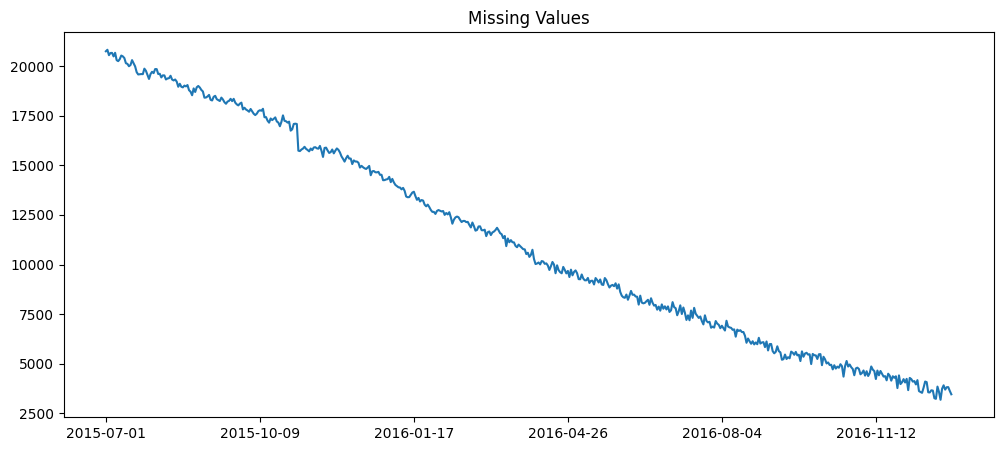

In [13]:
plt.figure(figsize=(12, 5))

df.isna().sum()[1:].plot()
plt.title('Missing Values')
plt.show()

**Insights:** From the plot, we can observe that the number of missing values decreases over time. Recent dates have fewer missing values, indicating that newer pages lack data for dates before they were hosted.

So, replacing all the null values with 0.

In [14]:
df.fillna(0,inplace =True)

In [15]:
df.isna().sum().sum()

0

## Basic data cleaning and exploration

The page name contains data in this format:

SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

In [16]:
# Regex pattern to check if all page name contains 'wikipedia.org_' domain
pattern = r'\.(\w+\.org)_'

df['Domain'] = df['Page'].str.extract(pattern)

# Display the updated DataFrame to verify the result
print(df[['Page', 'Domain']])

                                                     Page         Domain
0                 2NE1_zh.wikipedia.org_all-access_spider  wikipedia.org
1                  2PM_zh.wikipedia.org_all-access_spider  wikipedia.org
2                   3C_zh.wikipedia.org_all-access_spider  wikipedia.org
3              4minute_zh.wikipedia.org_all-access_spider  wikipedia.org
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  wikipedia.org
...                                                   ...            ...
145058  Underworld_(serie_de_películas)_es.wikipedia.o...  wikipedia.org
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...  wikipedia.org
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...  wikipedia.org
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...  wikipedia.org
145062  Francisco_el_matemático_(serie_de_televisión_d...  wikipedia.org

[145063 rows x 2 columns]


In [17]:
df['Domain'].unique()

array(['wikipedia.org', 'wikimedia.org', 'mediawiki.org'], dtype=object)

**Insights:** Not all pages belong to 'wikipedia.org'; 'wikimedia.org' and 'mediawiki.org' are also included in the dataset.

In [18]:
df['Domain'].value_counts()

,count
Domain,
wikipedia.org,127208
wikimedia.org,10555
mediawiki.org,7300


**Insights:**

*  wikipedia.org leads with 127208 mentions, showing dominant presence.
*  wikimedia.org and mediawiki.org have smaller shares, indicating niche roles.

### Extracting Title

In [19]:
# Step 1: Extract everything before the domain name
df['Raw_Title'] = df['Page'].str.extract(r'^(.*?)\.(?:wikipedia|wikimedia|mediawiki)\.org')

# Step 2: Remove the language code if present
df['Title'] = df['Raw_Title'].str.replace(r'(_[a-z]{2})$', '', regex=True)

# Clean up the intermediate column if desired
df.drop(columns=['Raw_Title'], inplace=True)

# Display the updated DataFrame to verify the result
df[['Page', 'Title']]

,Page,Title
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1
1,2PM_zh.wikipedia.org_all-access_spider,2PM
2,3C_zh.wikipedia.org_all-access_spider,3C
3,4minute_zh.wikipedia.org_all-access_spider,4minute
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You
...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,Underworld_(serie_de_películas)
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Resident_Evil:_Capítulo_Final
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Enamorándome_de_Ramón
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Hasta_el_último_hombre


In [20]:
df['Title'].nunique()

49286

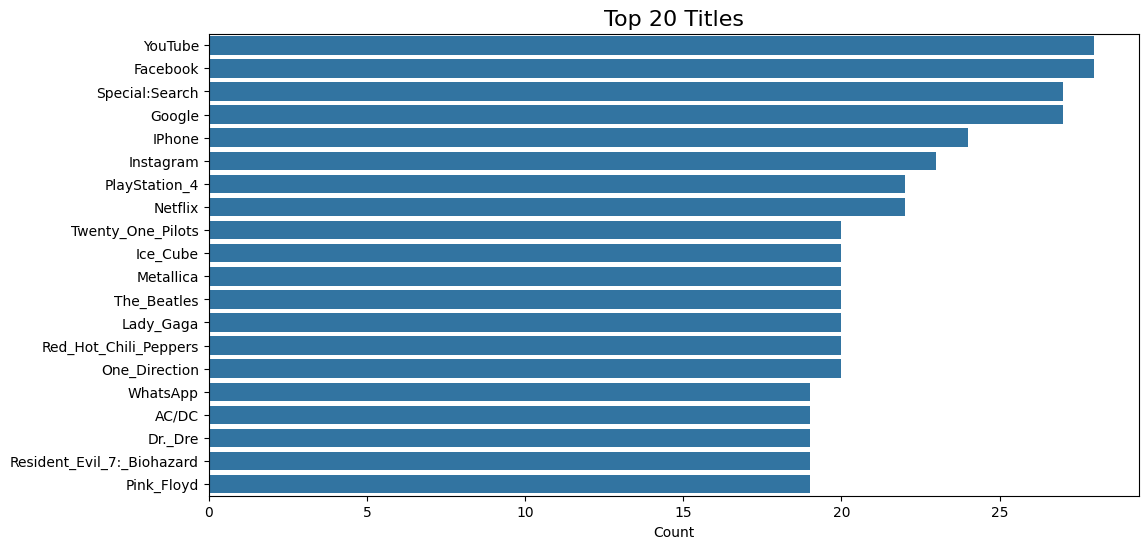

In [21]:
plt.figure(figsize=(12, 6))

top_titles = df['Title'].value_counts().head(20)

sns.barplot(x=top_titles.values, y=top_titles.index)
plt.title('Top 20 Titles', fontsize=16)
plt.xlabel('Count')
plt.ylabel('')  # Hide the y-label
plt.show()

In [22]:
print('No. of Pages cointaning YouTube: ',df[df['Page'].str.contains('YouTube')].shape[0])

df[df['Page'].str.contains('YouTube')][['Page','Title']].head(10)

No. of Pages cointaning YouTube:  68


,Page,Title
173,YouTube_zh.wikipedia.org_all-access_spider,YouTube
2250,觀看次數最多的YouTube視頻列表_zh.wikipedia.org_all-access...,觀看次數最多的YouTube視頻列表
7084,YouTube_fr.wikipedia.org_desktop_all-agents,YouTube
7627,Liste_des_vidéos_les_plus_visionnées_sur_YouTu...,Liste_des_vidéos_les_plus_visionnées_sur_YouTube
9713,List_of_most_disliked_YouTube_videos_en.wikipe...,List_of_most_disliked_YouTube_videos
9714,List_of_most_viewed_YouTube_videos_en.wikipedi...,List_of_most_viewed_YouTube_videos
11556,List_of_most_subscribed_users_on_YouTube_en.wi...,List_of_most_subscribed_users_on_YouTube
12512,List_of_the_most_subscribed_users_on_YouTube_e...,List_of_the_most_subscribed_users_on_YouTube
13117,YouTube_en.wikipedia.org_desktop_all-agents,YouTube
14529,File:YouTube_logo_2013.svg_commons.wikimedia.o...,File:YouTube_logo_2013.svg_commons


In [23]:
print('No. of Pages cointaning Facebook: ',df[df['Page'].str.contains('Facebook')].shape[0])

df[df['Page'].str.contains('Facebook')][['Page','Title']].head(10)

No. of Pages cointaning Facebook:  57


,Page,Title
47,Facebook_zh.wikipedia.org_all-access_spider,Facebook
4887,Facebook_fr.wikipedia.org_desktop_all-agents,Facebook
9078,Facebook_en.wikipedia.org_desktop_all-agents,Facebook
14090,File:Facebook_Messenger_logo.svg_commons.wikim...,File:Facebook_Messenger_logo.svg_commons
14091,File:Facebook_icon.jpg_commons.wikimedia.org_a...,File:Facebook_icon.jpg_commons
14092,File:Facebook_like_thumb.png_commons.wikimedia...,File:Facebook_like_thumb.png_commons
14698,Category:Facebook_commons.wikimedia.org_all-ac...,Category:Facebook_commons
15006,File:Facebook_icon.svg_commons.wikimedia.org_a...,File:Facebook_icon.svg_commons
15007,File:Facebook_logo_(square).png_commons.wikime...,File:Facebook_logo_(square).png_commons
15480,File:Facebook_New_Logo_(2015).svg_commons.wiki...,File:Facebook_New_Logo_(2015).svg_commons


**Insights:**

*  Top titles include major brands and artists, indicating high public interest in entertainment content.

*  YouTube and Facebook lead with equal counts, highlighting their dominance in digital engagement.

### Extracting Language

In [24]:
df.Page.sample(20)

,Page
83969,Extension:Kartographer_www.mediawiki.org_all-a...
49854,Grayanotoxin_de.wikipedia.org_all-access_spider
8932,Dennis_Hastert_en.wikipedia.org_desktop_all-ag...
2381,超級月亮_zh.wikipedia.org_all-access_spider
77943,Category:Videos_of_animal_sex_commons.wikimedi...
19553,"Брик,_Евгения_Владимировна_ru.wikipedia.org_mo..."
11629,Metallica_en.wikipedia.org_desktop_all-agents
58272,選抜高等学校野球大会_ja.wikipedia.org_mobile-web_all-agents
42280,Extension:SpamBlacklist_www.mediawiki.org_desk...
143802,Geometría_analítica_es.wikipedia.org_all-acces...


In [25]:
# Extracting the language using regex
df['Language'] = df['Page'].str.extract(r'_(.{2})\.(?:wikipedia|wikimedia|mediawiki)\.org')

# Display the DataFrame to verify the result
print(df[['Page', 'Language']])

                                                     Page Language
0                 2NE1_zh.wikipedia.org_all-access_spider       zh
1                  2PM_zh.wikipedia.org_all-access_spider       zh
2                   3C_zh.wikipedia.org_all-access_spider       zh
3              4minute_zh.wikipedia.org_all-access_spider       zh
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...       zh
...                                                   ...      ...
145058  Underworld_(serie_de_películas)_es.wikipedia.o...       es
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...       es
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...       es
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...       es
145062  Francisco_el_matemático_(serie_de_televisión_d...       es

[145063 rows x 2 columns]


In [26]:
df['Language'].unique()

array(['zh', 'fr', 'en', nan, 'ru', 'de', 'ja', 'es'], dtype=object)

In [27]:
df['Language'].isna().sum()

17855

In [28]:
df[df['Language'].isna()]['Page'].head(10)

,Page
13332,Accueil_commons.wikimedia.org_all-access_spider
13333,Atlas_of_Asia_commons.wikimedia.org_all-access...
13334,Atlas_of_Europe_commons.wikimedia.org_all-acce...
13335,Atlas_of_World_War_II_commons.wikimedia.org_al...
13336,Atlas_of_colonialism_commons.wikimedia.org_all...
13337,Atlas_of_the_United_Kingdom_commons.wikimedia....
13338,Atlas_of_the_United_States_commons.wikimedia.o...
13339,Bikini_commons.wikimedia.org_all-access_spider
13340,Campaign:OFBA2016_commons.wikimedia.org_all-ac...
13341,Catalogue_of_Wilhelm_von_Gloeden's_pictures_co...


In [29]:
# Check if all rows having null Language are of domain 'wikimedia.org' or 'mediawiki.org'

null_language = df[df['Language'].isna()]

null_language[
    null_language['Page'].str.contains('wikimedia') |
    null_language['Page'].str.contains('mediawiki')
].shape[0]

17855

**Insights:** A total of 17855 rows with a null language are associated with wikimedia or mediawiki pages, specifically indicated by "commons".

In [30]:
df['Language'].value_counts()

,count
Language,
en,24108
ja,20431
de,18547
fr,17802
zh,17229
ru,15022
es,14069


In [31]:
language_map = {
    'de': 'German',
    'en': 'English',
    'es': 'Spanish',
    'fr': 'French',
    'ja': 'Japanese',
    'ru': 'Russian',
    'zh': 'Chinese'
}

# Replace language codes with names and NaN with 'Unknown'
df['Language'] = df['Language'].replace(language_map).fillna('Unknown')

In [32]:
df['Language'].unique()

array(['Chinese', 'French', 'English', 'Unknown', 'Russian', 'German',
       'Japanese', 'Spanish'], dtype=object)

In [33]:
df['Language'].isna().sum()

0

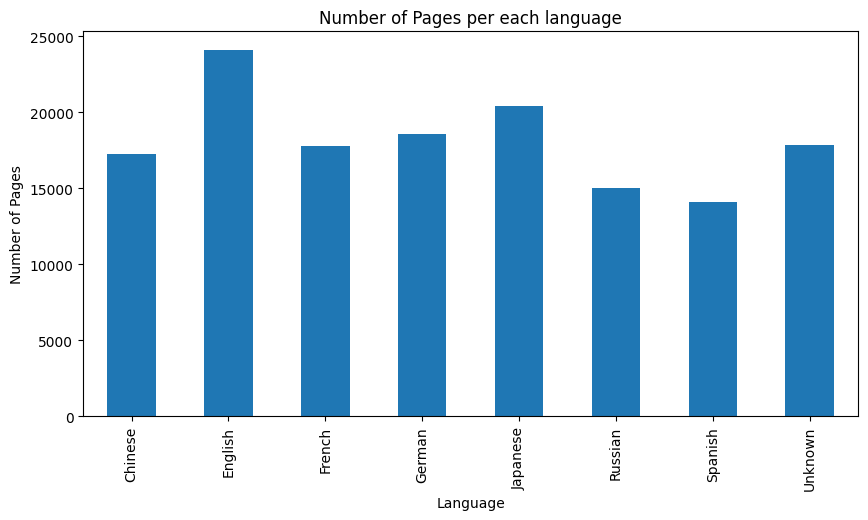

In [34]:
plt.figure(figsize=(10, 5))

df.groupby('Language')['Page'].count().plot(kind='bar')
plt.xlabel('Language')
plt.ylabel('Number of Pages')
plt.title('Number of Pages per each language')
plt.show()

In [35]:
df['Language'].value_counts(normalize=True)*100

,proportion
Language,
English,16.618986
Japanese,14.084225
German,12.785479
Unknown,12.308445
French,12.271909
Chinese,11.876909
Russian,10.355501
Spanish,9.698545


**Insights:**

*  English dominates pages, comprising over 16.61% of total.
*  Japanese and German follow closely, showcasing diverse content.
*  12.30% of pages have an unknown language and belong to either the "wikimedia.org" or "mediawiki.org" domain.

### Extracting ACCESS TYPE

In [36]:
# Regex pattern to find text after domain and before the next underscore
pattern = r'(?:wikipedia|wikimedia|mediawiki)\.org_(.*?)_'

df['Access_Type'] = df['Page'].str.extract(pattern)

# Display the updated DataFrame to verify the result
print(df[['Page', 'Access_Type']])

                                                     Page Access_Type
0                 2NE1_zh.wikipedia.org_all-access_spider  all-access
1                  2PM_zh.wikipedia.org_all-access_spider  all-access
2                   3C_zh.wikipedia.org_all-access_spider  all-access
3              4minute_zh.wikipedia.org_all-access_spider  all-access
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  all-access
...                                                   ...         ...
145058  Underworld_(serie_de_películas)_es.wikipedia.o...  all-access
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...  all-access
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...  all-access
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...  all-access
145062  Francisco_el_matemático_(serie_de_televisión_d...  all-access

[145063 rows x 2 columns]


In [37]:
df['Access_Type'].unique()

array(['all-access', 'desktop', 'mobile-web'], dtype=object)

In [38]:
df['Access_Type'].value_counts()

,count
Access_Type,
all-access,74315
mobile-web,35939
desktop,34809


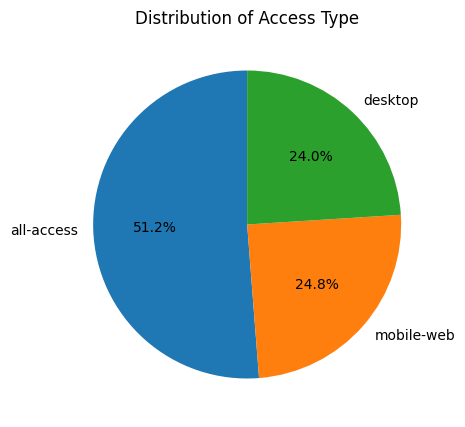

In [39]:
plt.figure(figsize=(5, 5))

text_counts = df['Access_Type'].value_counts(normalize=True) * 100

text_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Access Type')
plt.ylabel('')  # Hide the y-label
plt.show()

**Insights:**

* All-access type accounts for over half of the total, indicating a broad audience reach.
*  Mobile-web and desktop access are almost evenly distributed, suggesting diverse user preferences for browsing.

### Extracting ACCESS ORIGIN

In [40]:
# Extracting text after the last underscore using regex
pattern = r'_([^_]*)$'

df['Access_Origin'] = df['Page'].str.extract(pattern)

# Display the updated DataFrame to verify the result
print(df[['Page', 'Access_Origin']])

                                                     Page Access_Origin
0                 2NE1_zh.wikipedia.org_all-access_spider        spider
1                  2PM_zh.wikipedia.org_all-access_spider        spider
2                   3C_zh.wikipedia.org_all-access_spider        spider
3              4minute_zh.wikipedia.org_all-access_spider        spider
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...        spider
...                                                   ...           ...
145058  Underworld_(serie_de_películas)_es.wikipedia.o...        spider
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...        spider
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...        spider
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...        spider
145062  Francisco_el_matemático_(serie_de_televisión_d...        spider

[145063 rows x 2 columns]


In [41]:
df['Access_Origin'].unique()

array(['spider', 'all-agents'], dtype=object)

In [42]:
df['Access_Origin'].value_counts()

,count
Access_Origin,
all-agents,110150
spider,34913


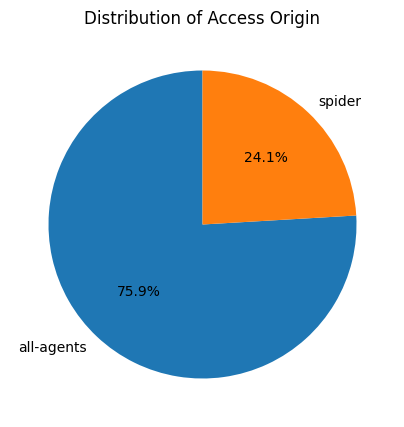

In [43]:
plt.figure(figsize=(5, 5))

text_counts = df['Access_Origin'].value_counts(normalize=True) * 100

text_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Access Origin')
plt.ylabel('')  # Hide the y-label
plt.show()

**Insights:**

*  Most of the access (75.9%) comes from all-agents, showing high user interaction levels.
*  Spiders contribute to 24.1% of access, indicating considerable automated web crawling activities.

## Aggregate and Pivoting

In [44]:
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Domain,Title,Language,Access_Type,Access_Origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,20.0,22.0,19.0,18.0,20.0,wikipedia.org,2NE1,Chinese,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,30.0,52.0,45.0,26.0,20.0,wikipedia.org,2PM,Chinese,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,6.0,3.0,4.0,17.0,wikipedia.org,3C,Chinese,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,11.0,17.0,19.0,10.0,11.0,wikipedia.org,4minute,Chinese,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,27.0,13.0,36.0,10.0,wikipedia.org,52_Hz_I_Love_You,Chinese,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,13.0,3.0,5.0,10.0,wikipedia.org,Underworld_(serie_de_películas),Spanish,all-access,spider
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,wikipedia.org,Resident_Evil:_Capítulo_Final,Spanish,all-access,spider
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,wikipedia.org,Enamorándome_de_Ramón,Spanish,all-access,spider
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,wikipedia.org,Hasta_el_último_hombre,Spanish,all-access,spider


In [45]:
agg_df = df.drop(['Page','Domain','Title','Access_Type','Access_Origin'],axis = 1).groupby('Language').mean().T.drop('Unknown',axis = 1).reset_index()
agg_df

Language,index,Chinese,English,French,German,Japanese,Russian,Spanish
0,2015-07-01,240.582042,3513.862203,475.150994,714.968405,580.647056,629.999601,1085.972919
1,2015-07-02,240.941958,3502.511407,478.202000,705.229741,666.672801,640.902876,1037.814557
2,2015-07-03,239.344071,3325.357889,459.837659,676.877231,602.289805,594.026295,954.412680
3,2015-07-04,241.653491,3462.054256,491.508932,621.145145,756.509177,558.728132,896.050750
4,2015-07-05,257.779674,3575.520035,482.557746,722.076185,725.720914,595.029157,974.508210
...,...,...,...,...,...,...,...,...
545,2016-12-27,376.019618,6040.680728,858.413100,1085.095379,789.158680,1001.209426,1133.367901
546,2016-12-28,378.048639,5860.227559,774.155769,1032.640804,790.500465,931.987685,1178.290923
547,2016-12-29,350.719427,6245.127510,752.712954,994.657141,865.483236,897.282452,1112.171085
548,2016-12-30,354.704452,5201.783018,700.543422,949.265649,952.018354,803.271868,821.671405


In [46]:
agg_df['index'] = pd.to_datetime(agg_df['index'])
agg_df = agg_df.set_index('index')

agg_df

Language,Chinese,English,French,German,Japanese,Russian,Spanish
index,,,,,,,
2015-07-01,240.582042,3513.862203,475.150994,714.968405,580.647056,629.999601,1085.972919
2015-07-02,240.941958,3502.511407,478.202000,705.229741,666.672801,640.902876,1037.814557
2015-07-03,239.344071,3325.357889,459.837659,676.877231,602.289805,594.026295,954.412680
2015-07-04,241.653491,3462.054256,491.508932,621.145145,756.509177,558.728132,896.050750
2015-07-05,257.779674,3575.520035,482.557746,722.076185,725.720914,595.029157,974.508210
...,...,...,...,...,...,...,...
2016-12-27,376.019618,6040.680728,858.413100,1085.095379,789.158680,1001.209426,1133.367901
2016-12-28,378.048639,5860.227559,774.155769,1032.640804,790.500465,931.987685,1178.290923
2016-12-29,350.719427,6245.127510,752.712954,994.657141,865.483236,897.282452,1112.171085


In [47]:
agg_df.shape

(550, 7)

In [48]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japanese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
dtypes: float64(7)
memory usage: 34.4 KB


In [49]:
agg_df.columns

Index(['Chinese', 'English', 'French', 'German', 'Japanese', 'Russian',
       'Spanish'],
      dtype='object', name='Language')

In [50]:
agg_df.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='index', length=550, freq=None)

**Insights:** The data has been transformed into a time series format, ready for ARIMA models.

## Time series plot

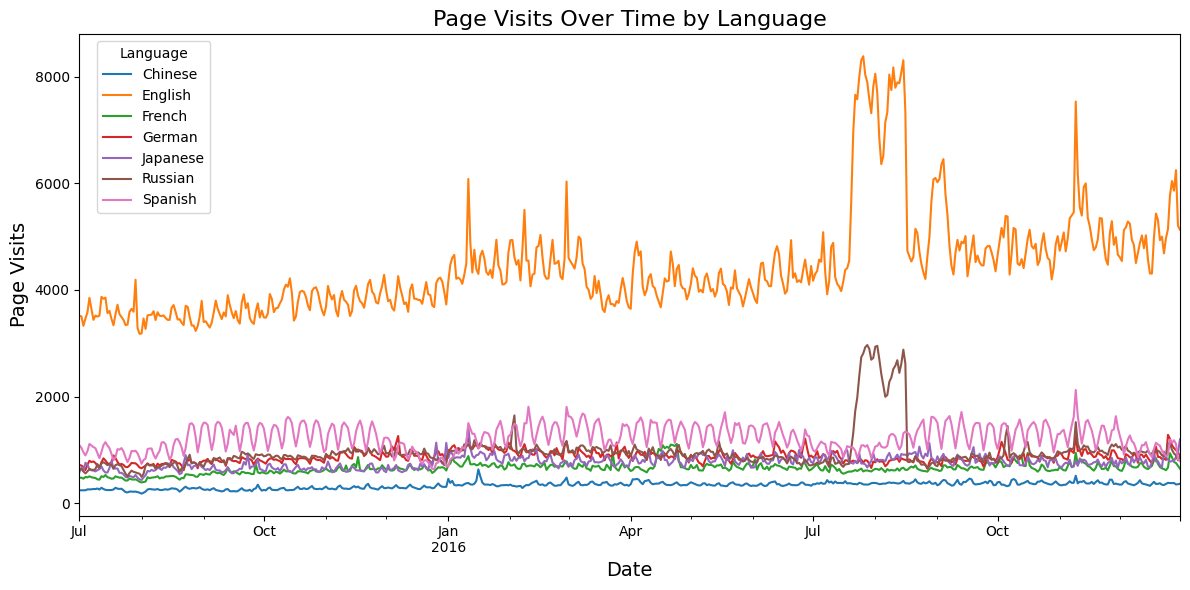

In [51]:
plt.figure(figsize=(12, 6))

# Plot the DataFrame directly
agg_df.plot(ax=plt.gca())

# Setting the plot title and labels
plt.title('Page Visits Over Time by Language', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Page Visits', fontsize=14)

# Adding legend and formatting
plt.legend(title='Language', bbox_to_anchor=(0.01, 1), loc='upper left')
plt.tight_layout()

plt.show()

**Insights:**

*  **English leads page visits:** English pages consistently attract the highest traffic, with noticeable peaks over time.

*  **Significant spikes in English:** Mid-2016 shows spikes in English traffic, indicating major events or trends.

*  **Stable activity in other languages:** Non-English languages have stable traffic, with Russian showing occasional surges.

## Stationarity

### Dickey-Fuller test

- **Null Hypothesis:** The series is Not Stationary
- **Alternative Hypothesis:** The series is Stationary

- **Significant value:** 0.05 (alpha)

  - If p-value > 0.05: We fail to reject Null hypothesis, this means the series is Not Stationary.
  - If p-value <= 0.05: We reject Null Hypothesis, this means the time series is Stationary.

In [52]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
def adf_test(series, column):
    result = adfuller(series)
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    print('Stationary' if result[1] < 0.05 else 'Not Stationary')

# Apply the function to each column
for lang in agg_df.columns:
  adf_test(agg_df[lang],lang)
  print('\n******************************************\n',end='\n')

ADF Statistic for Chinese: -1.668432836868615
p-value: 0.4474457922931142
Critical Value 1%: -3.4427485933555886
Critical Value 5%: -2.8670087381529723
Critical Value 10%: -2.569682641509434
Not Stationary

******************************************

ADF Statistic for English: -2.2472840057446803
p-value: 0.18953359279992404
Critical Value 1%: -3.4426321555520905
Critical Value 5%: -2.86695748394138
Critical Value 10%: -2.5696553279762426
Not Stationary

******************************************

ADF Statistic for French: -2.8498753294717973
p-value: 0.05149502195245795
Critical Value 1%: -3.442609129942274
Critical Value 5%: -2.866947348175723
Critical Value 10%: -2.569649926626197
Not Stationary

******************************************

ADF Statistic for German: -2.4027070426468455
p-value: 0.14097382319729534
Critical Value 1%: -3.442678467240966
Critical Value 5%: -2.8669778698997543
Critical Value 10%: -2.5696661916864083
Not Stationary

***************************************

**Insights:**

*  The Dickey-Fuller test indicates that Russian and Spanish page visit time series are stationary.
*  Chinese, English, German, Japanese, and French page visit time series are non-stationary.

### Decomposition of series

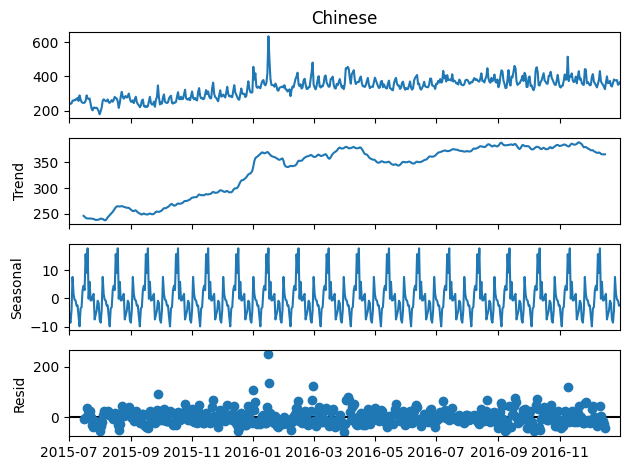


Dickey-Fuller test for residual of Chinese
ADF Statistic for Chinese: -7.022951544576664
p-value: 6.47242329007122e-10
Critical Value 1%: -3.443496379464
Critical Value 5%: -2.8673378563200003
Critical Value 10%: -2.569858036
Stationary


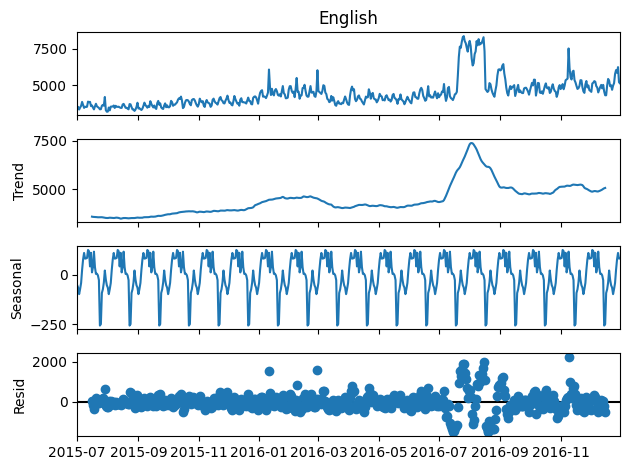


Dickey-Fuller test for residual of English
ADF Statistic for English: -6.436840612729284
p-value: 1.6448178745768292e-08
Critical Value 1%: -3.44336554668393
Critical Value 5%: -2.867280279529963
Critical Value 10%: -2.5698273512400744
Stationary


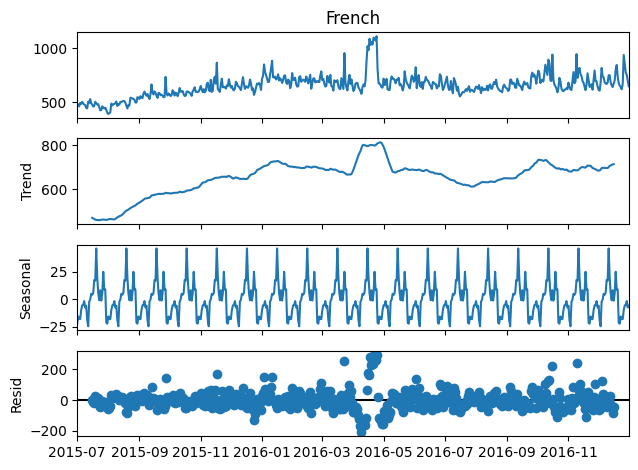


Dickey-Fuller test for residual of French
ADF Statistic for French: -8.022264274919356
p-value: 2.061209738910441e-12
Critical Value 1%: -3.443391504492468
Critical Value 5%: -2.8672917032172953
Critical Value 10%: -2.5698334393109095
Stationary


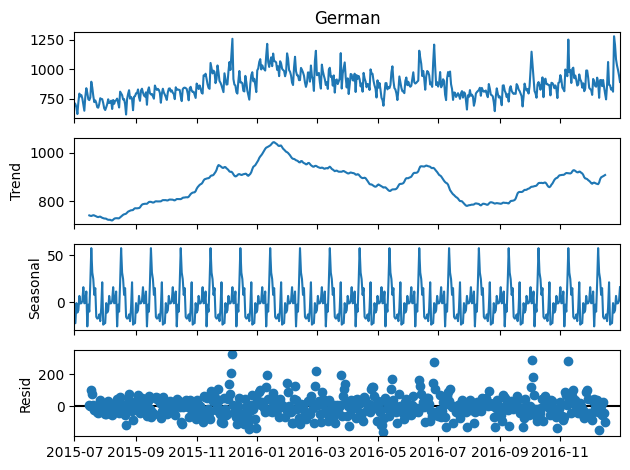


Dickey-Fuller test for residual of German
ADF Statistic for German: -7.536393429277168
p-value: 3.469328888216792e-11
Critical Value 1%: -3.4434175660489905
Critical Value 5%: -2.8673031724657454
Critical Value 10%: -2.5698395516760275
Stationary


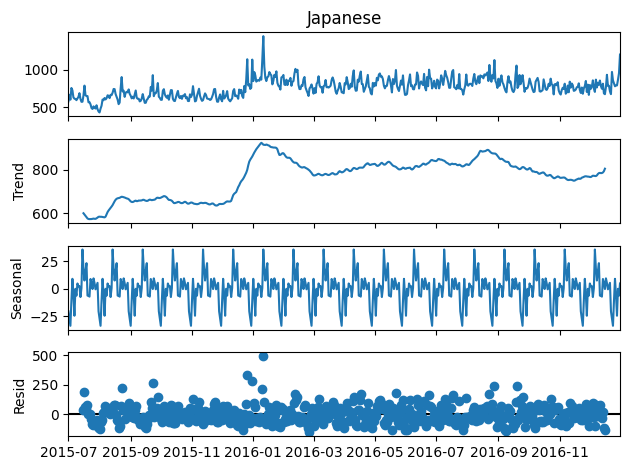


Dickey-Fuller test for residual of Japanese
ADF Statistic for Japanese: -8.333889074695541
p-value: 3.3120777812066466e-13
Critical Value 1%: -3.44328828958775
Critical Value 5%: -2.8672462791357867
Critical Value 10%: -2.569809231353463
Stationary


In [53]:
import statsmodels.api as sm

# Decomposition of the series
def decompose_series(data, column):
    decomposition = sm.tsa.seasonal_decompose(data[column], model='additive', period=30)
    fig = decomposition.plot()
    plt.show()

    print(f'\nDickey-Fuller test for residual of {lang}',end='\n')
    adf_test(pd.Series(decomposition.resid).dropna(),lang)

# Apply the function to each column
for lang in ['Chinese', 'English', 'French', 'German', 'Japanese']:
    decompose_series(agg_df,lang)

**Insights:** The residuals from the time series decomposition for all non-stationary languages (`Chinese`, `English`, `French`, `German` and `Japanese`) are stationary.

### Differencing the series

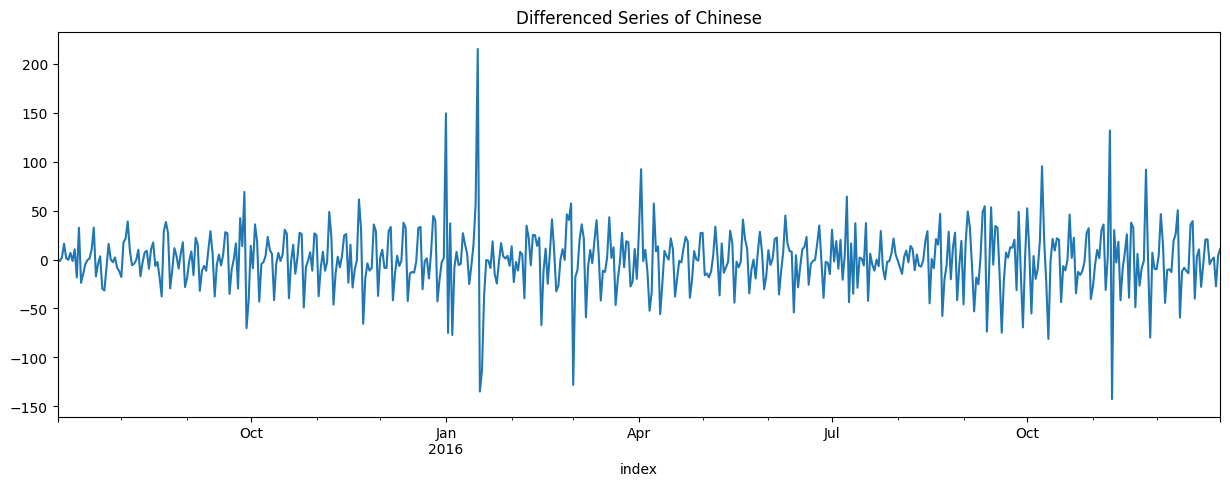


 Dickey-Fuller test for differenced Series of Chinese
ADF Statistic for Chinese: -7.722331285138035
p-value: 1.1835533827549121e-11
Critical Value 1%: -3.442772146350605
Critical Value 5%: -2.8670191055991836
Critical Value 10%: -2.5696881663873414
Stationary


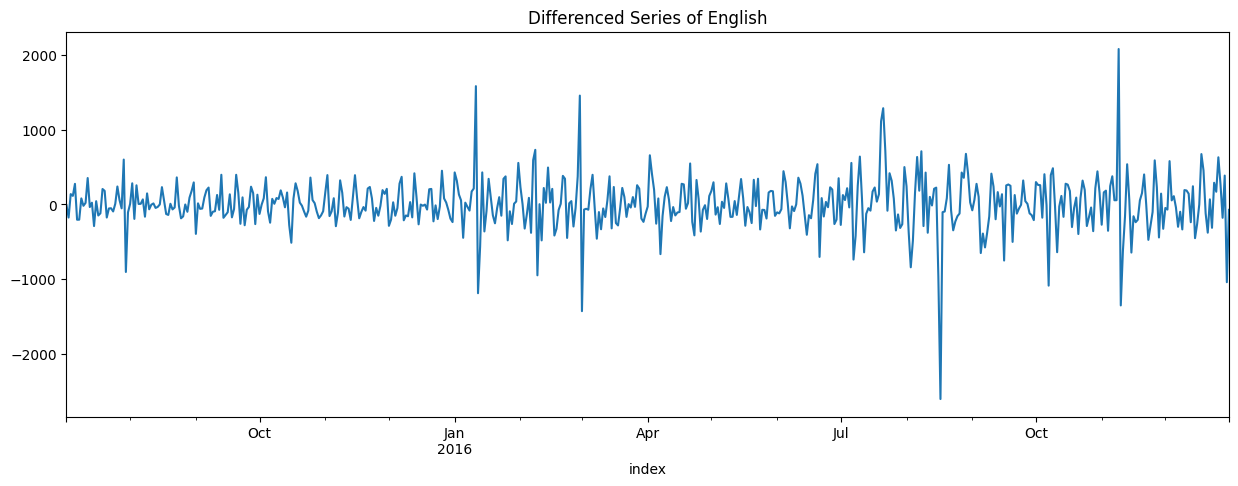


 Dickey-Fuller test for differenced Series of English
ADF Statistic for English: -8.25415310489571
p-value: 5.292474635436075e-13
Critical Value 1%: -3.4426321555520905
Critical Value 5%: -2.86695748394138
Critical Value 10%: -2.5696553279762426
Stationary


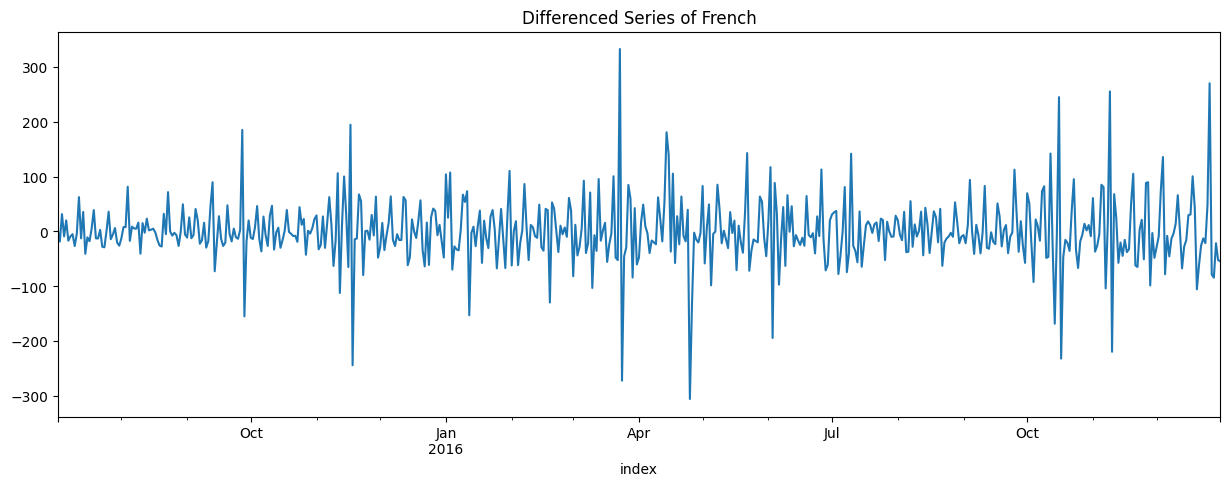


 Dickey-Fuller test for differenced Series of French
ADF Statistic for French: -10.102723976145077
p-value: 1.0491385280030118e-17
Critical Value 1%: -3.442609129942274
Critical Value 5%: -2.866947348175723
Critical Value 10%: -2.569649926626197
Stationary


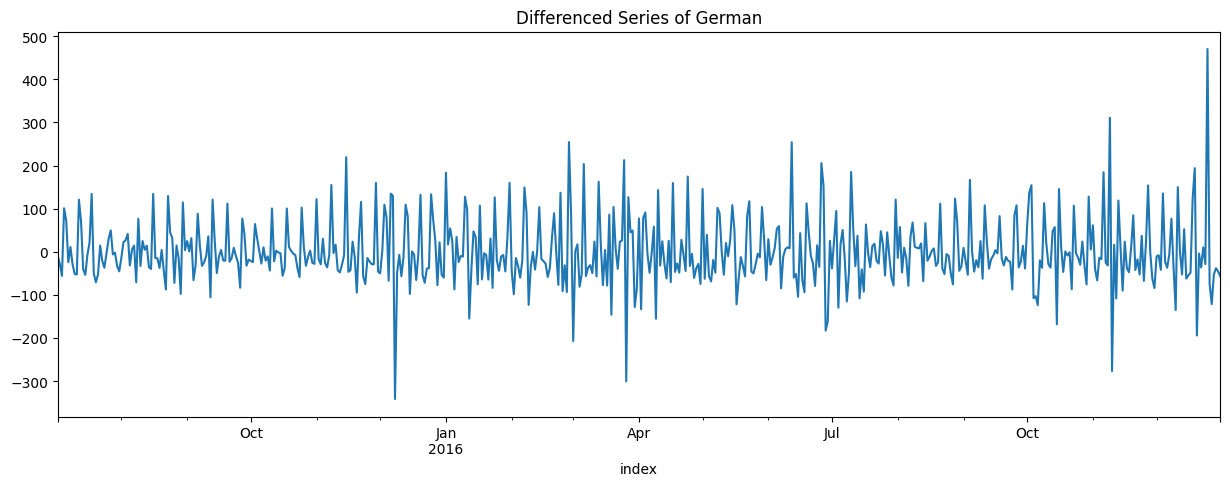


 Dickey-Fuller test for differenced Series of German
ADF Statistic for German: -7.20692406551705
p-value: 2.28739763760522e-10
Critical Value 1%: -3.442772146350605
Critical Value 5%: -2.8670191055991836
Critical Value 10%: -2.5696881663873414
Stationary


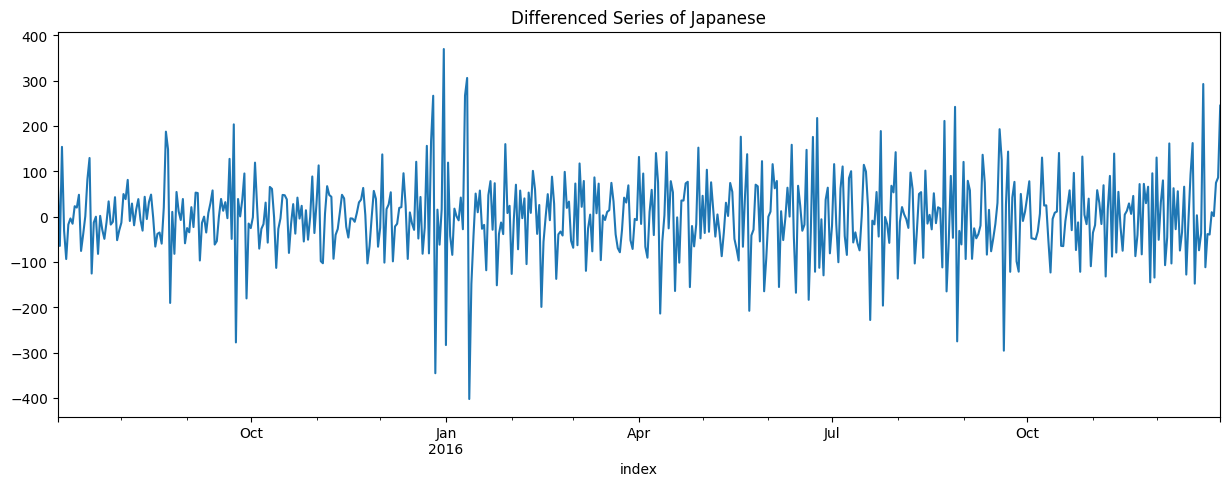


 Dickey-Fuller test for differenced Series of Japanese
ADF Statistic for Japanese: -11.014704045198407
p-value: 6.198597931119363e-20
Critical Value 1%: -3.442495284887805
Critical Value 5%: -2.86689723299801
Critical Value 10%: -2.5696232204003677
Stationary


In [54]:
# Differencing the series
def difference_series(data, column):
    plt.figure(figsize = (15,5))
    data[f'{column}_diff'] = data[column].diff()
    data[f'{column}_diff'].dropna().plot(title=f'Differenced Series of {column}')
    plt.show()

    # Check stationarity using ADF test
    print(f'\n Dickey-Fuller test for differenced Series of {column}',end='\n')
    adf_test(data[f'{column}_diff'].dropna(), column)

# Apply the function to each column
for lang in ['Chinese', 'English', 'French', 'German', 'Japanese']:
    difference_series(agg_df,lang)

**Insights:**

After one differentiation, all non-stationary time series becomes stationary.

Thus, for these languages in ARIMA models, we can set d = 1.

### Plotting the ACF and PACF plots

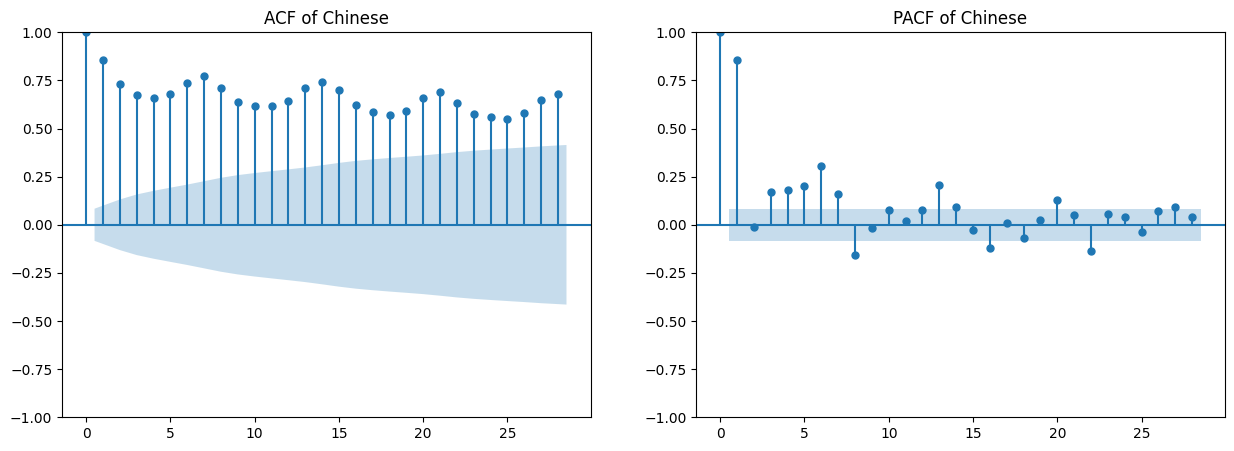

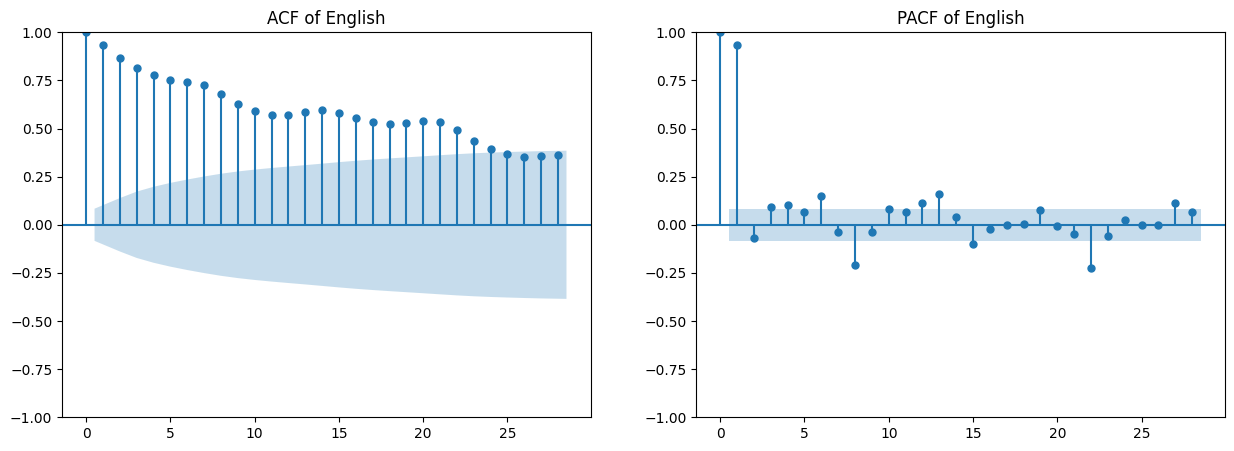

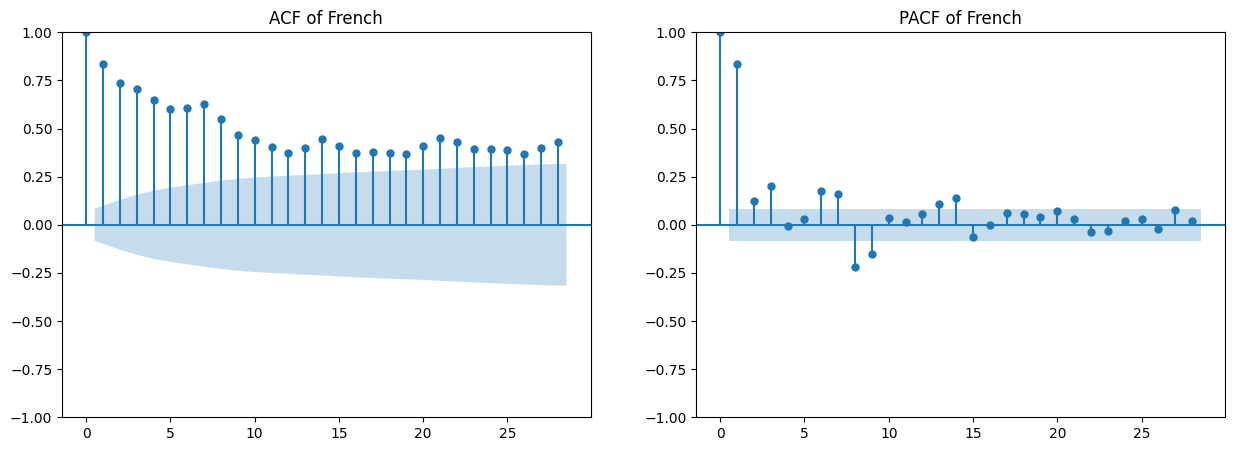

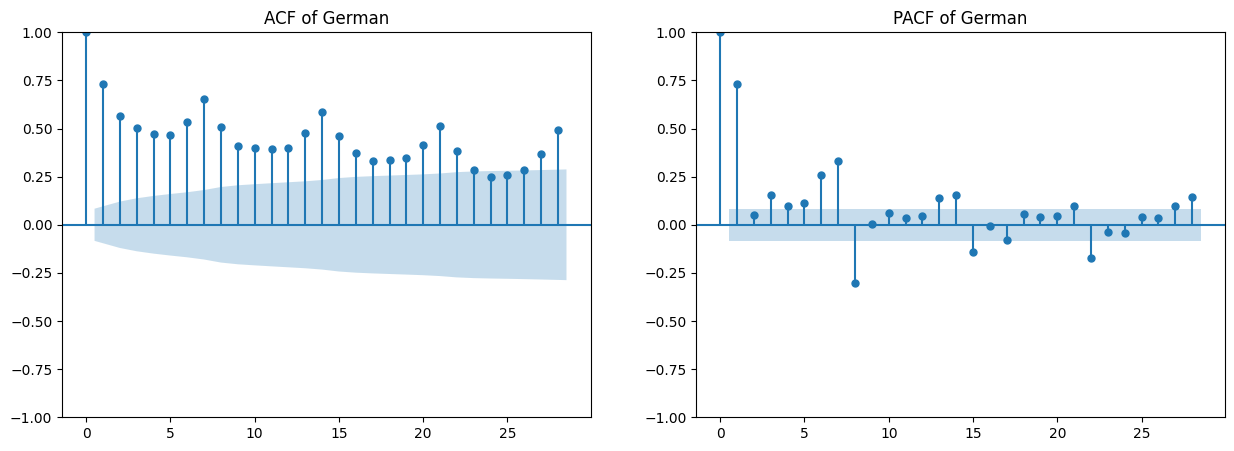

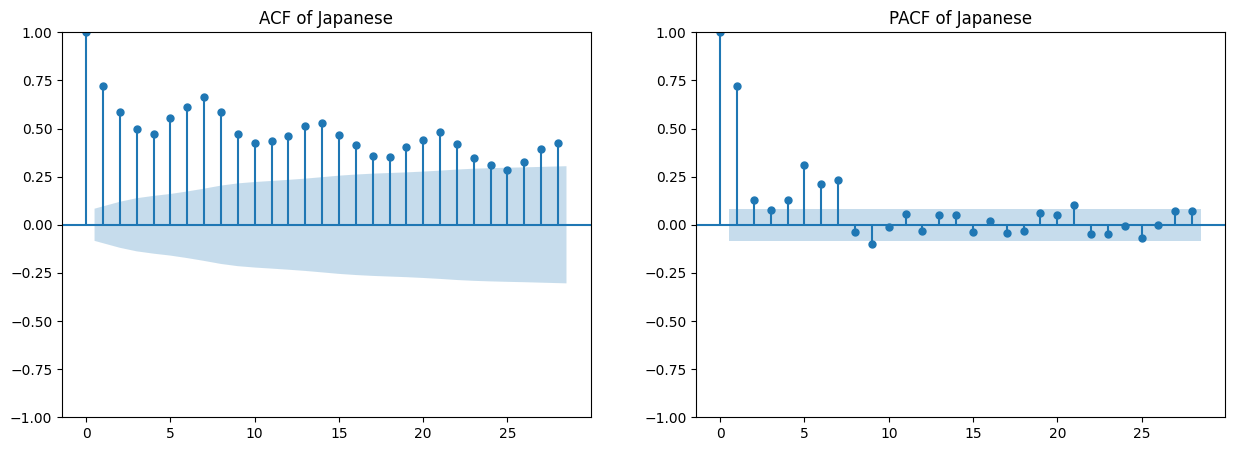

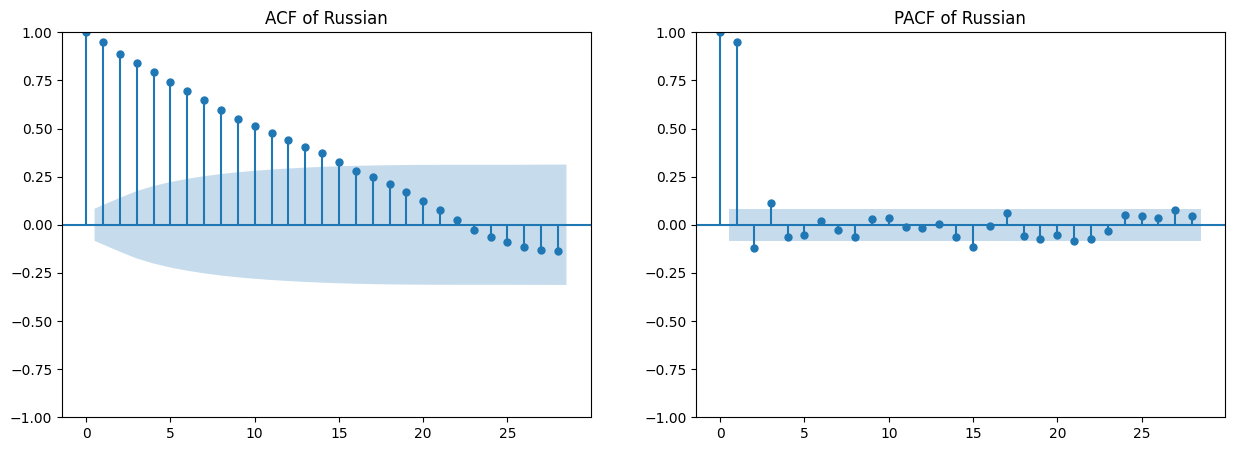

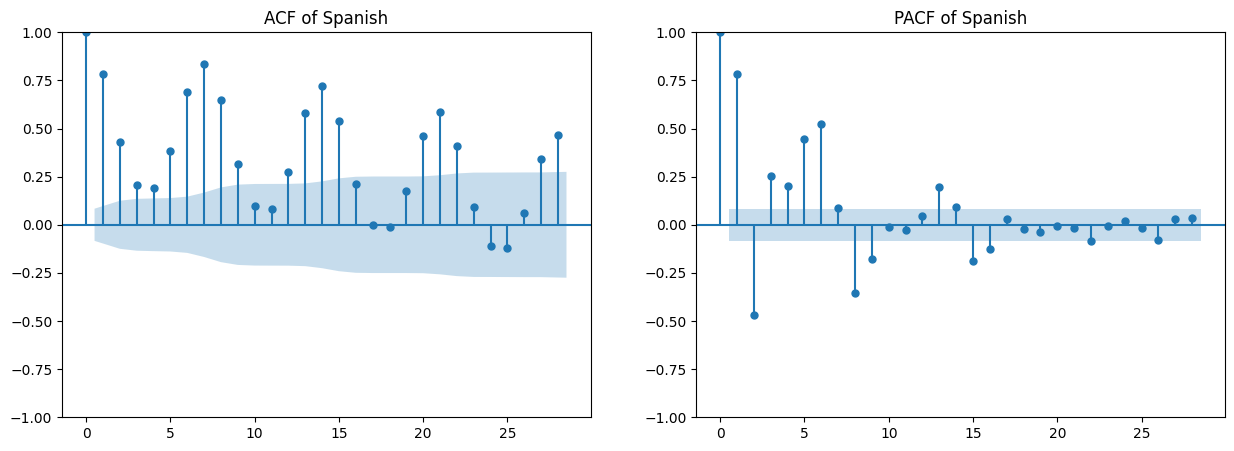

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF
def plot_acf_pacf(series, column):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(series.dropna(), ax=ax[0], title=f'ACF of {column}')
    plot_pacf(series.dropna(), ax=ax[1], title=f'PACF of {column}')
    plt.show()

# Apply the function to each column
for lang in ['Chinese', 'English', 'French', 'German', 'Japanese', 'Russian', 'Spanish']:
  plot_acf_pacf(agg_df[lang],lang)

**Insights:** The ACF & PACF plot shows weekly seasonality, with significant autocorrelation spikes every 7 lags, indicating recurring weekly patterns.

## Forecasting

**Let's apply model on English language first.**

In [56]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [57]:
import warnings
warnings.simplefilter('ignore')

### Exponential smoothing

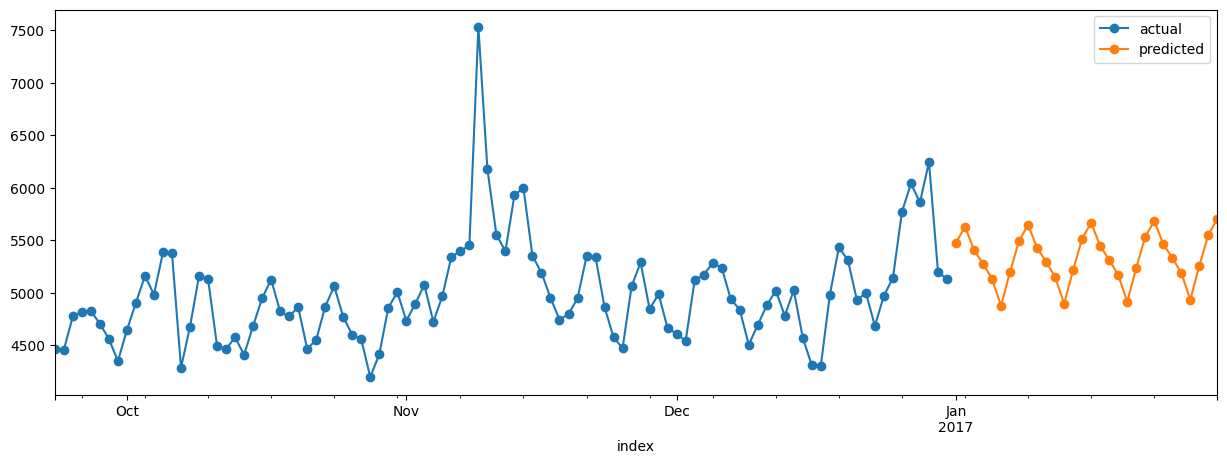

In [58]:
model = sm.tsa.ExponentialSmoothing(agg_df.English, seasonal='add',trend='add')
model = model.fit()

plt.figure(figsize = (15,5))
agg_df.English.tail(100).plot(style='-o', label='actual')
model.forecast(30).plot(style='-o', label='predicted')
plt.legend()
plt.show()

MAE : 394.976
RMSE : 563.349
MAPE: 0.073


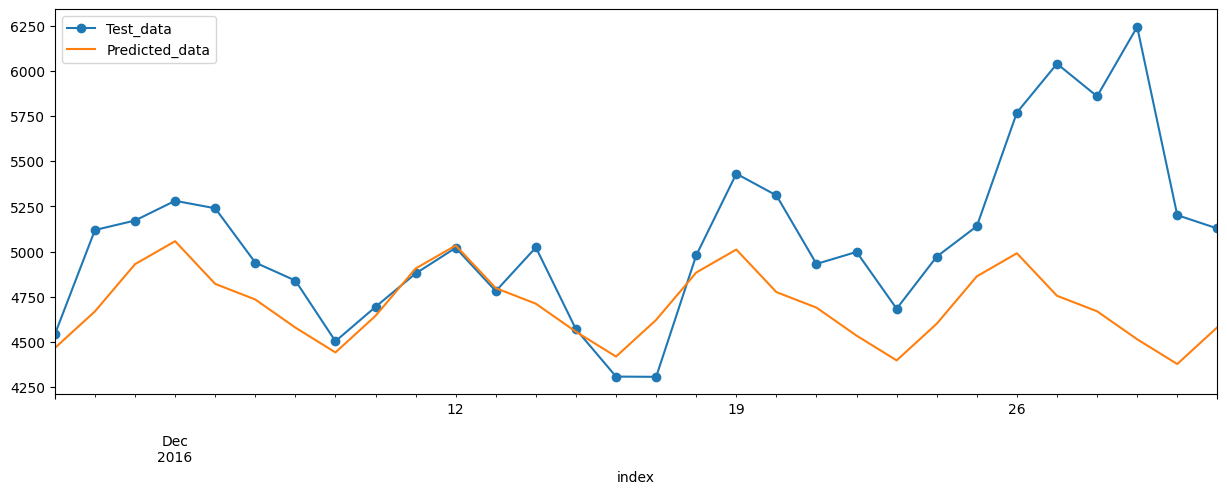

In [59]:
X_train = agg_df.English.loc[agg_df.English.index < agg_df.English.index[-30]].copy()
X_test = agg_df.English.loc[agg_df.English.index >= agg_df.English.index[-30]].copy()

model = sm.tsa.ExponentialSmoothing(X_train,
                                    trend='add',
                                    damped_trend='add',
                                    seasonal='add')
model = model.fit(smoothing_level=None,          # alpha
                  smoothing_trend=None,          # beta
                  smoothing_seasonal=None)       # gama)

pred = model.forecast(steps=30)
performance(X_test,pred)

plt.figure(figsize = (15,5))
X_test.plot(style='-o',label ='Test_data')
pred.plot(label='Predicted_data')
plt.legend()
plt.show()

**Insights:** The plot indicates that the model performs well, with a MAPE error of 7.3%.

### ARIMA Family

The ARIMA model serves as the foundation for various ARIMA-type models, accommodating extensions such as exogenous regressors and seasonal components. Its most comprehensive form is represented by **SARIMAX(p, d, q)x(P, D, Q, s)**, which encompasses:

*  Autoregressive models (AR(p))
*  Moving average models (MA(q))
*  Mixed autoregressive moving average models (ARMA(p, q))
*  Integration models (ARIMA(p, d, q))
*  Seasonal models (SARIMA(P, D, Q, s))

Regression with errors following ARIMA-type models.

### ARIMA model

In [60]:
time_series = agg_df.English

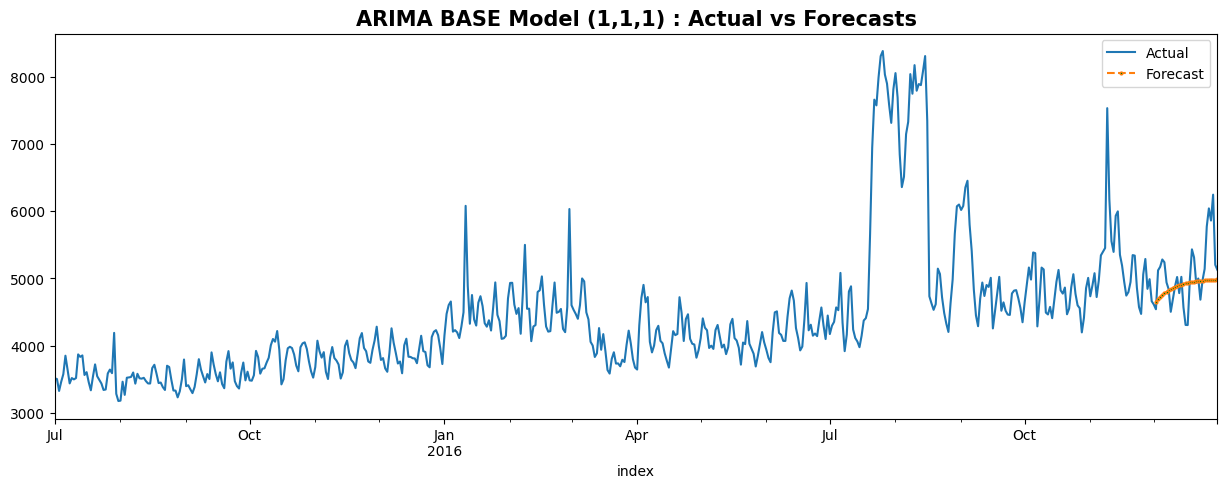


MAPE of Model : 0.06585
RMSE of Model : 472.186


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(time_series[:-30],order = (1,1,1))
model = model.fit()

predicted = model.forecast(steps= 30, alpha = 0.05)

plt.figure(figsize = (15,5))
time_series.plot(label = 'Actual')
predicted.plot(label = 'Forecast', linestyle='dashed', marker='o',markerfacecolor='green', markersize=2)
plt.legend(loc="upper right")
plt.title('ARIMA BASE Model (1,1,1) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()


# Calculating MAPE & RMSE
actuals = time_series.values[-30:]
errors = time_series.values[-30:] - predicted.values

mape = np.mean(np.abs(errors)/ np.abs(actuals))
rmse = np.sqrt(np.mean(errors**2))

print()
print(f'MAPE of Model : {np.round(mape,5)}')
print(f'RMSE of Model : {np.round(rmse,3)}')

### SARIMAX model

In [62]:
def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):

    # Creating SARIMAX Model with order=(p,d,q) & seasonal_order=(P, D, Q, s)
    model = SARIMAX(time_series[:-n],
                    order =(p,d,q),
                    seasonal_order=(P, D, Q, s),
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()

    # Creating forecast for last n-values
    model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))

    # Plotting Actual & Forecasted values

    plt.figure(figsize = (15,5))
    time_series[-60:].plot(label = 'Actual')
    model_forecast[-60:].plot(label = 'Forecast', color = 'red',
                              linestyle='dashed', marker='o',markerfacecolor='red', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
    plt.show()

    # Calculating MAPE & RMSE
    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - model_forecast.values

    mape = np.mean(np.abs(errors)/ np.abs(actuals))
    rmse = np.sqrt(np.mean(errors**2))

    print(f'MAPE of Model : {np.round(mape,5)}')
    print(f'RMSE of Model : {np.round(rmse,3)}')

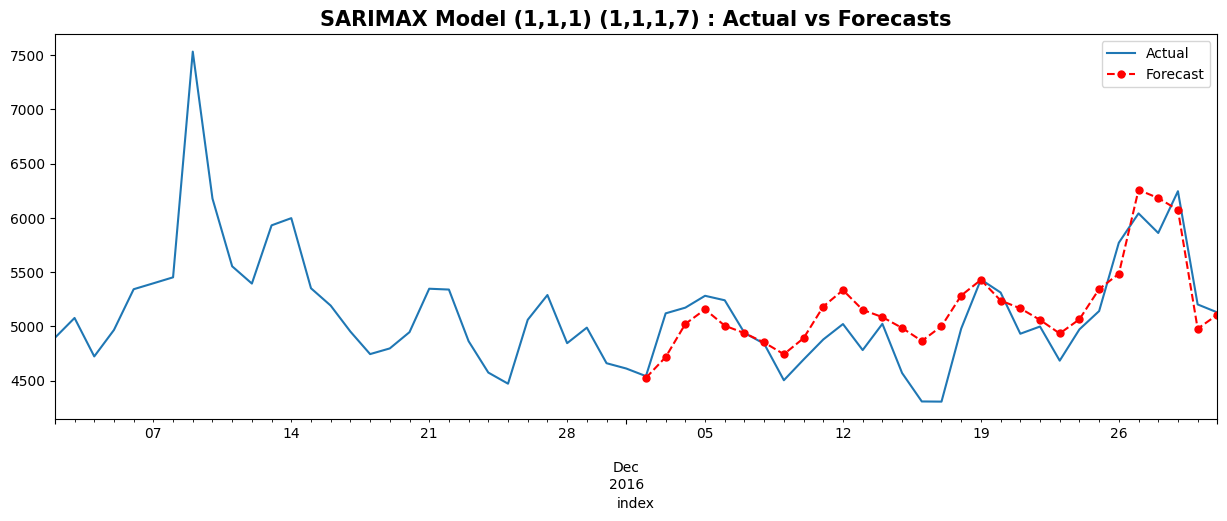

MAPE of Model : 0.04453
RMSE of Model : 272.731


In [63]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = agg_df.English
test_size = 0.1
p,d,q,P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog=exog)

### Hyperparamer tuning for SARIMAX model

In [64]:
def SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog = []):
    counter = 0
    # Creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])

    # Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                # Creating Model
                                model = SARIMAX(time_series[:-n],
                                                order=(p,d,q),
                                                seasonal_order=(P, D, Q, s),
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit()

                                # Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))

                                # Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values

                                # Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)

                                # Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row

                # Print statement to check progress of Loop
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

    return param_df

In [65]:
# Finding best parameters for English time series

exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = agg_df.English
n = 30
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [66]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
317,318,"(2, 1, 2)","(1, 1, 2, 7)",0.04054,246.918
209,210,"(1, 1, 2)","(1, 1, 2, 7)",0.04163,252.820
323,324,"(2, 1, 2)","(2, 1, 2, 7)",0.04197,258.336
40,41,"(0, 0, 2)","(0, 1, 1, 7)",0.04199,276.311
41,42,"(0, 0, 2)","(0, 1, 2, 7)",0.04206,271.577


Best possible parameters: p ,d, q, P, D, Q, s = 2, 1, 2, 1, 1, 2, 7

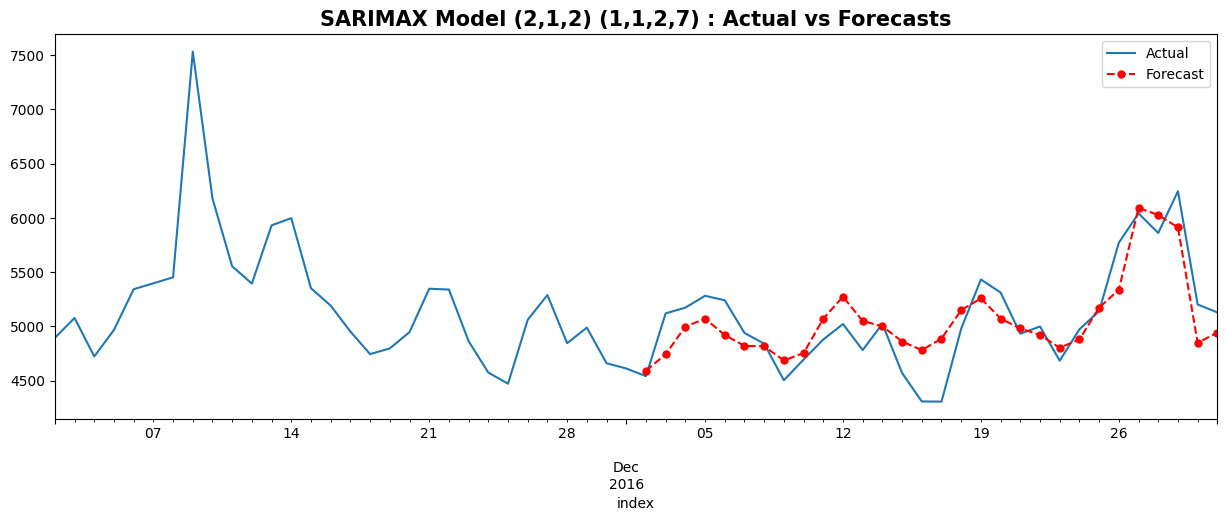

MAPE of Model : 0.04054
RMSE of Model : 246.918


In [67]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = agg_df.English
test_size = 0.1
p,d,q,P,D,Q,s = 2,1,2,1,1,2,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog=exog)

## Hyperparameter tuning for all languages

In [68]:
def pipeline_sarimax_grid_search_without_exog(languages, data, n, param, d_param, s_param):

    best_param_df  = pd.DataFrame(columns = ['languages','p','d', 'q', 'P','D','Q','s','mape'])
    for lang in languages:
        print('')
        print('')
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        counter = 0
        time_series = data[lang]
        best_mape = 100

        # Creating loop for every paramater to fit SARIMAX model
        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    # Creating Model
                                    model = SARIMAX(time_series[:-n],
                                                    order=(p,d,q),
                                                    seasonal_order=(P, D, Q, s),
                                                    initialization='approximate_diffuse')
                                    model_fit = model.fit()

                                    # Creating forecast from Model
                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    # Calculating errors for results
                                    actuals = time_series.values[-n:]
                                    errors = time_series.values[-n:] - model_forecast.values

                                    # Calculating MAPE & RMSE
                                    mape = np.mean(np.abs(errors)/ np.abs(actuals))

                                    counter += 1

                                    if (mape < best_mape):
                                        best_mape = mape
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass

                    # Print statement to check progress of Loop
                    print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')

        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row

    return best_param_df

In [69]:
languages = ['Chinese', 'French', 'German', 'Japanese', 'Russian', 'Spanish']
n = 30
param = [0,1,2]
d_param = [0,1]
s_param = [7]

best_param_df = pipeline_sarimax_grid_search_without_exog(languages, agg_df, n, param, d_param, s_param)



--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculat

In [70]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,languages,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,0,1,0,2,7,0.03074
4,Russian,0,0,2,1,0,1,7,0.04166
1,French,0,0,2,2,1,2,7,0.06359
2,German,0,1,1,1,0,1,7,0.06578
3,Japanese,0,1,2,2,1,0,7,0.07122
5,Spanish,0,1,0,2,1,0,7,0.08561


In [85]:
def plot_best_SARIMAX_model(languages, data, n, best_param_df):

    for lang in languages:

        # Fetching respective best parameters for that language
        p = best_param_df.loc[best_param_df['languages'] == lang, ['p']].values[0][0]
        d = best_param_df.loc[best_param_df['languages'] == lang, ['d']].values[0][0]
        q = best_param_df.loc[best_param_df['languages'] == lang, ['q']].values[0][0]
        P = best_param_df.loc[best_param_df['languages'] == lang, ['P']].values[0][0]
        D = best_param_df.loc[best_param_df['languages'] == lang, ['D']].values[0][0]
        Q = best_param_df.loc[best_param_df['languages'] == lang, ['Q']].values[0][0]
        s = best_param_df.loc[best_param_df['languages'] == lang, ['s']].values[0][0]

        # Creating language time-series
        time_series = data[lang]

        # Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s)
        model = SARIMAX(time_series[:-n],
                        order =(p,d,q),
                        seasonal_order=(P, D, Q, s),
                        initialization='approximate_diffuse')
        model_fit = model.fit()

        # Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic = True)

        # Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values

        mape = np.mean(np.abs(errors)/ np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))

        print('')
        print(f'-----------------------------------------------------------------------------------------')
        print(f'        SARIMAX model for {lang} Time Series                                             ')
        print(f'        Parameters of Model : ({p},{d},{q}) ({P},{D},{Q},{s})                            ')
        print(f'        MAPE of Model       : {np.round(mape,5)}                                         ')
        print(f'        RMSE of Model       : {np.round(rmse,3)}                                         ')
        print(f'-----------------------------------------------------------------------------------------')

        # Plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize = (15,5))
        time_series[-60:].plot(label = 'Actual')
        model_forecast[-60:].plot(label = 'Forecast', color = 'red',
                                  linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
        plt.show()

    return None


-----------------------------------------------------------------------------------------
        SARIMAX model for Chinese Time Series                                             
        Parameters of Model : (0,1,0) (1,0,2,7)                            
        MAPE of Model       : 0.03074                                         
        RMSE of Model       : 14.486                                         
-----------------------------------------------------------------------------------------


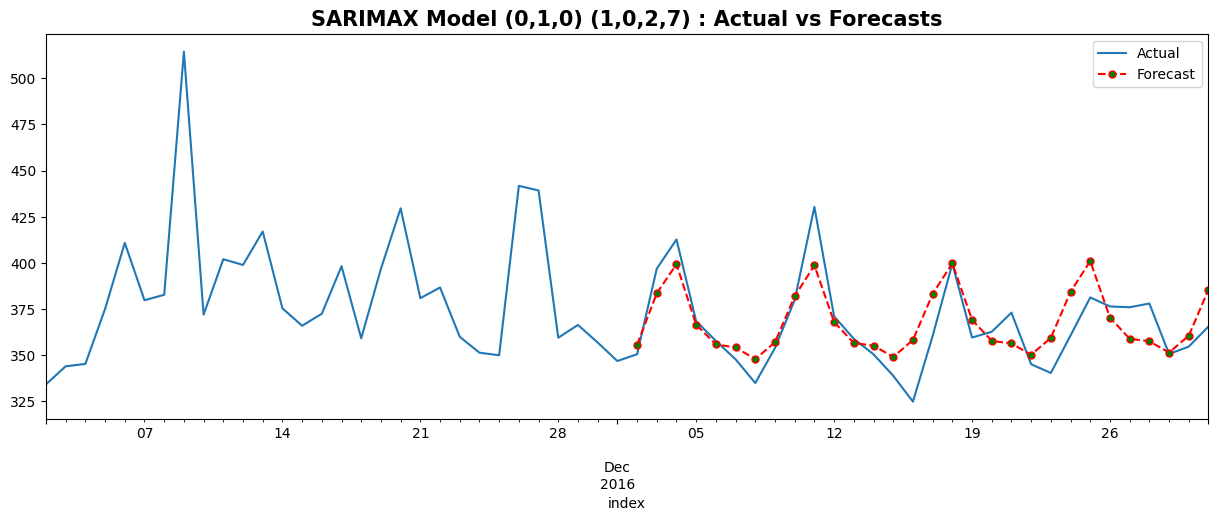


-----------------------------------------------------------------------------------------
        SARIMAX model for French Time Series                                             
        Parameters of Model : (0,0,2) (2,1,2,7)                            
        MAPE of Model       : 0.06359                                         
        RMSE of Model       : 72.572                                         
-----------------------------------------------------------------------------------------


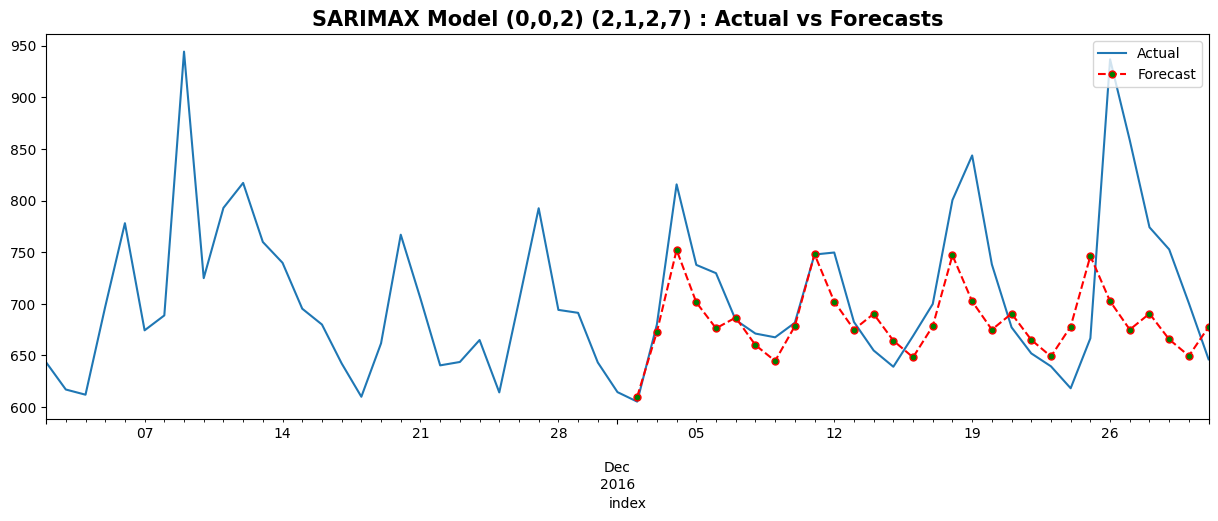


-----------------------------------------------------------------------------------------
        SARIMAX model for German Time Series                                             
        Parameters of Model : (0,1,1) (1,0,1,7)                            
        MAPE of Model       : 0.06578                                         
        RMSE of Model       : 110.62                                         
-----------------------------------------------------------------------------------------


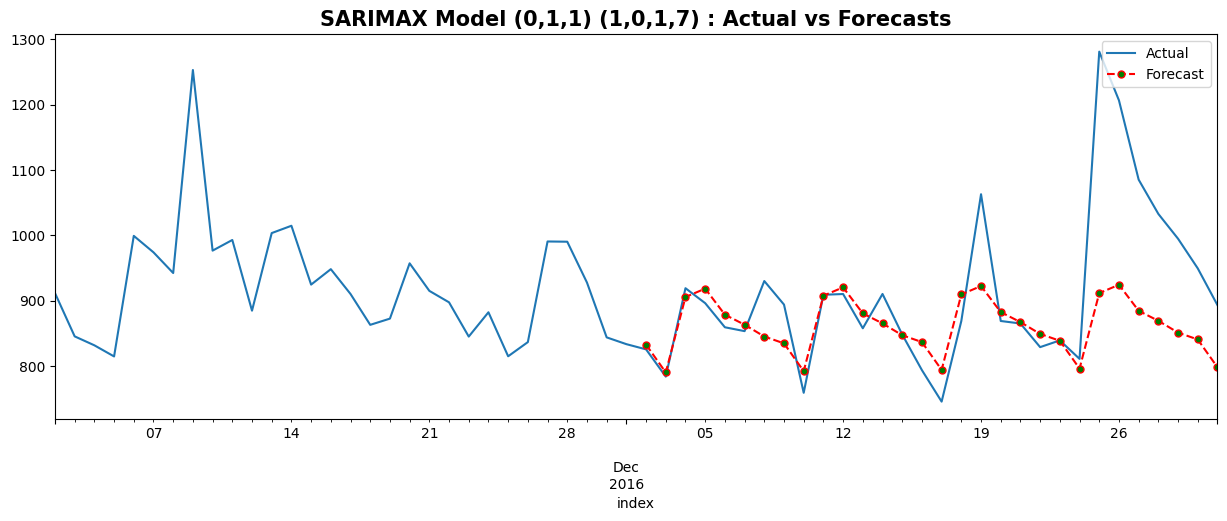


-----------------------------------------------------------------------------------------
        SARIMAX model for Japanese Time Series                                             
        Parameters of Model : (0,1,2) (2,1,0,7)                            
        MAPE of Model       : 0.07122                                         
        RMSE of Model       : 90.833                                         
-----------------------------------------------------------------------------------------


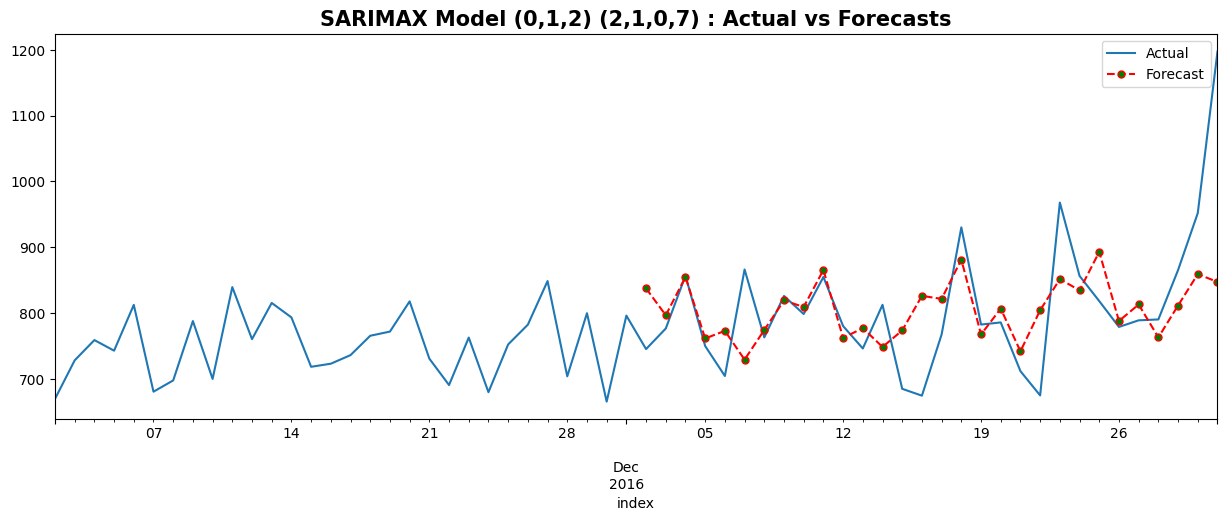


-----------------------------------------------------------------------------------------
        SARIMAX model for Russian Time Series                                             
        Parameters of Model : (0,0,2) (1,0,1,7)                            
        MAPE of Model       : 0.04166                                         
        RMSE of Model       : 52.025                                         
-----------------------------------------------------------------------------------------


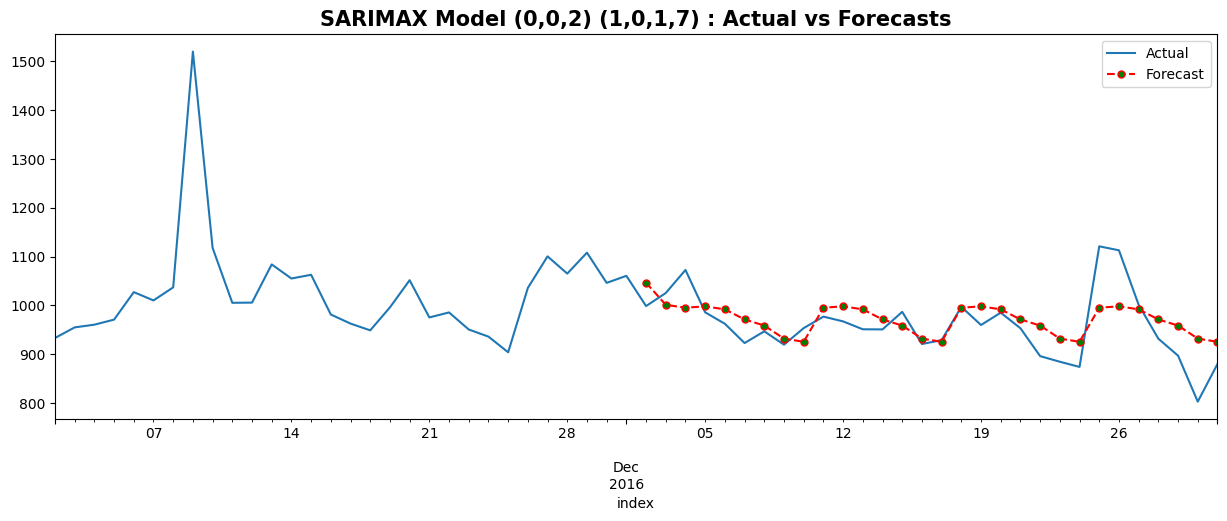


-----------------------------------------------------------------------------------------
        SARIMAX model for Spanish Time Series                                             
        Parameters of Model : (0,1,0) (2,1,0,7)                            
        MAPE of Model       : 0.08561                                         
        RMSE of Model       : 109.03                                         
-----------------------------------------------------------------------------------------


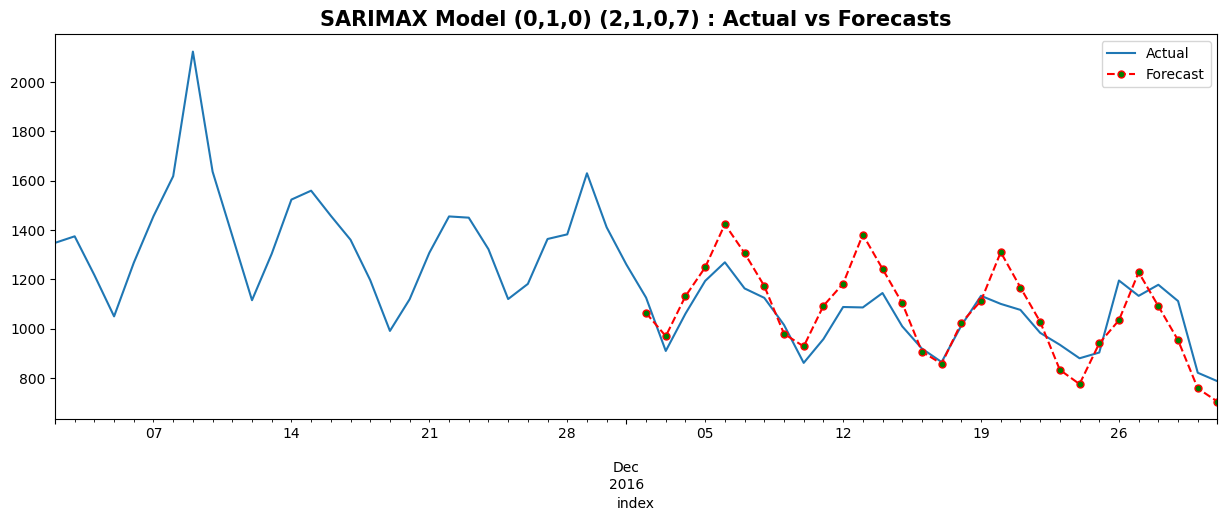

In [86]:
# Plotting SARIMAX model for each Language Time Series
languages = np.array(['Chinese', 'French', 'German', 'Japanese', 'Russian', 'Spanish'])
n = 30
plot_best_SARIMAX_model(languages, agg_df, n, best_param_df)

## Forecasting using Facebook Prophet

In [87]:
!pip install pystan~=2.14
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 80.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [88]:
from prophet import Prophet

In [89]:
time_series = agg_df
time_series = time_series.reset_index()
time_series = time_series[['index', 'English']]
time_series.columns = ['ds', 'y']
exog = Exog_Campaign_eng.copy(deep = True)
time_series['exog'] = exog.values

In [90]:
time_series

,ds,y,exog
0,2015-07-01,3513.862203,0
1,2015-07-02,3502.511407,0
2,2015-07-03,3325.357889,0
3,2015-07-04,3462.054256,0
4,2015-07-05,3575.520035,0
...,...,...,...
545,2016-12-27,6040.680728,1
546,2016-12-28,5860.227559,1
547,2016-12-29,6245.127510,1
548,2016-12-30,5201.783018,0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfzryj6zp/03pnv5sn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfzryj6zp/m1cgoej7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36382', 'data', 'file=/tmp/tmpfzryj6zp/03pnv5sn.json', 'init=/tmp/tmpfzryj6zp/m1cgoej7.json', 'output', 'file=/tmp/tmpfzryj6zp/prophet_model77a132du/prophet_model-20241027094655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


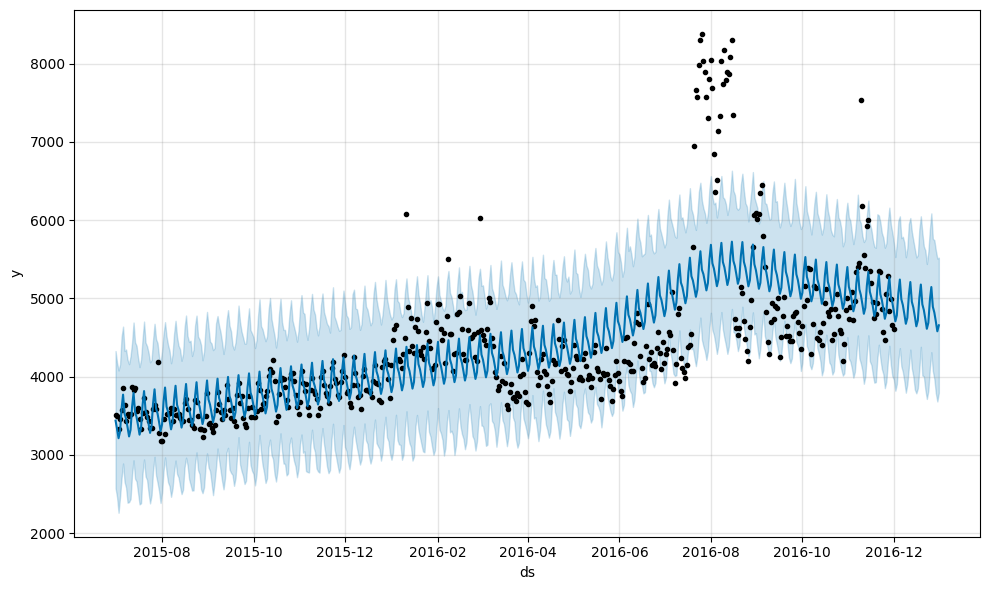

In [91]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfzryj6zp/ia07pbcs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfzryj6zp/2_l5ucdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22076', 'data', 'file=/tmp/tmpfzryj6zp/ia07pbcs.json', 'init=/tmp/tmpfzryj6zp/2_l5ucdp.json', 'output', 'file=/tmp/tmpfzryj6zp/prophet_modeltkp0cov4/prophet_model-20241027094701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


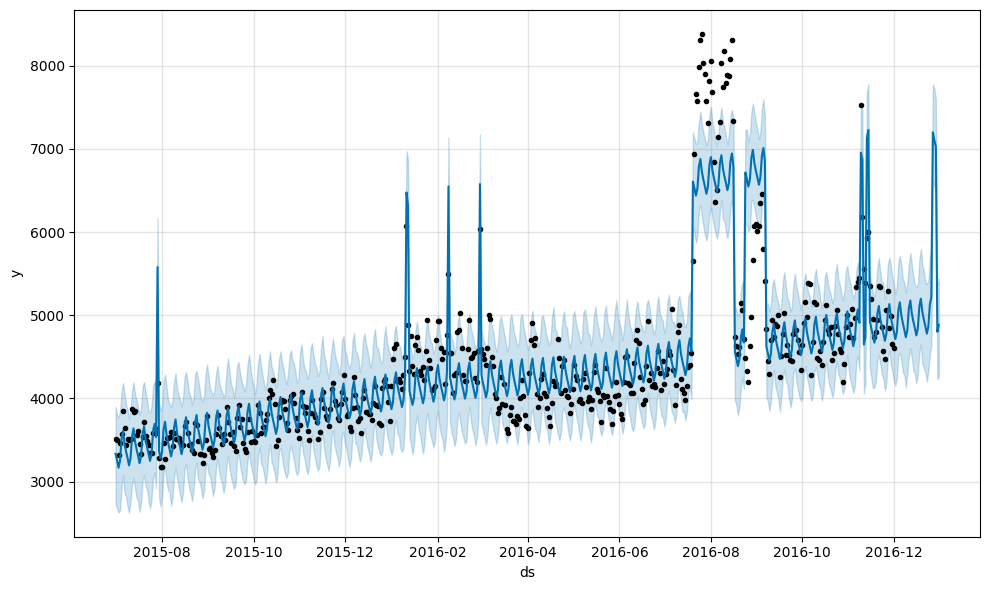

In [92]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

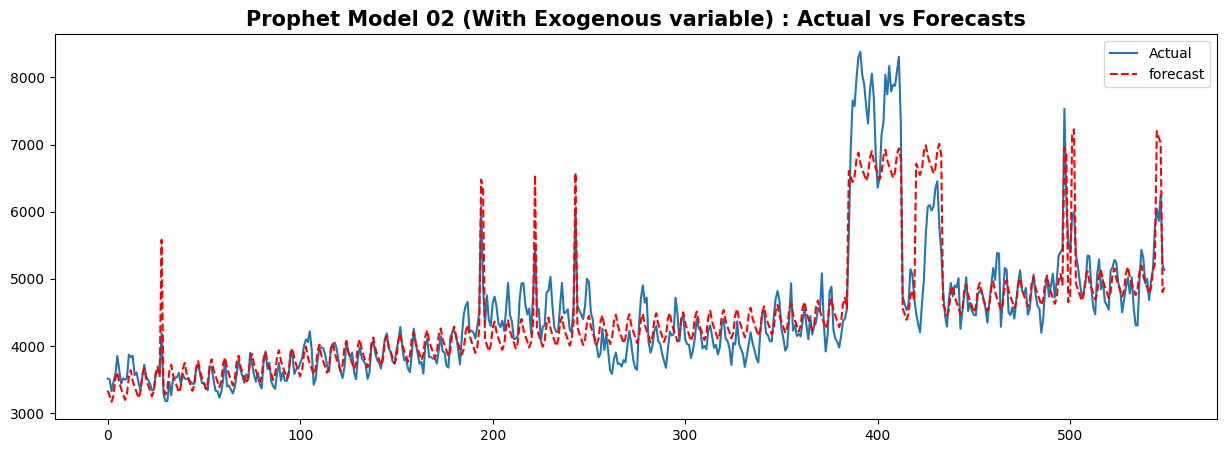

In [93]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

plt.figure(figsize = (15,5))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

In [94]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.05945140053559279

## Questionnaire

#### **Inferences made from the data visualizations:**

*  The data includes a total of 7 languages, with English having the most pages.
*  While 'wikipedia.org' is the most prominent with 127208 mentions, 'wikimedia.org' and 'mediawiki.org' also contribute, though on a smaller scale with 17855 mentions, indicating niche roles.
*  3 Access types:
    *  All-access:    51.2 %
    *  Mobile-web:    24.8 %
    *  Desktop:       24.0 %
*  2 Access origins:
    *  Agents:    75.9 %
    *  Spider:    24.1 %
*  English pages have the highest volume, making them ideal for ad placements.

#### **What does the decomposition of series do?**

The decomposition of a time series involves breaking down the series into distinct components — trend, seasonality, and residuals — to better understand the underlying patterns.

**Purpose:** The goal is to simplify the analysis by isolating different patterns in the data, making complex time series easier to interpret and work with.

**Components:**
*  Trend: Represents the long-term direction or movement in the data, showing how values change over an extended period.
*  Seasonality: Captures repeating patterns that occur at regular intervals, such as daily, weekly, or yearly cycles.
*  Residuals: Account for the random variations or noise in the data that remain after removing the trend and seasonality components.

**Applications:** Decomposition is useful for identifying distinct patterns in time series analysis and is often employed to forecast future values. By isolating the seasonality and trend, it can also enhance the accuracy of statistical or machine learning models when applied to the residuals.

#### **What level of differencing gave you a stationary series?**

Stationarity is a crucial property in time series analysis, as many techniques require the time series to be stationary.

**Definition:** A time series is considered stationary if its mean, variance, and autocorrelation remain constant over time.

**Differencing:** A common approach to achieve stationarity is differencing, where the value at a previous time step is subtracted from the current value. This process helps eliminate trend and seasonal patterns, making the time series more stable.

**Order of Differencing:** This refers to how many times the differencing operation is applied to achieve stationarity.

**Application:** In this case study, applying a single differencing step was sufficient to transform the time series into a stationary form.

#### **Difference between arima, sarima & sarimax.**


**1. ARIMA (AutoRegressive Integrated Moving Average)**

**Purpose:** Used for modeling and forecasting non-seasonal, stationary time series data.

**Components:**
  *  Autoregressive (AR) part: Uses past values to predict future values.
  *  Integrated (I) part: Involves differencing the series to make it stationary.
  *  Moving Average (MA) part: Uses past forecast errors in the model.

**Notation:** ARIMA(p, d, q), where:
  *  p: Order of the autoregression.
  *  d: Order of differencing.
  *  q: Order of the moving average.

**Limitations:** Cannot directly handle seasonal patterns without additional modifications.


---
---



**2. SARIMA (Seasonal AutoRegressive Integrated Moving Average)**

**Purpose:** Extends ARIMA to account for seasonality in time series data.

**Seasonality:** Explicitly models repeating patterns over fixed intervals (e.g., daily, monthly, yearly).

**Components:** Combines ARIMA components with seasonal terms.

**Notation:** SARIMA(p, d, q)(P, D, Q, S), where:
  *  p, d, q: As in ARIMA.
  *  P: Order of the seasonal autoregression.
  *  D: Order of seasonal differencing.
  *  Q: Order of the seasonal moving average.
  *  S: Number of time periods in each season.

**Advantage:** Effectively captures both non-seasonal and seasonal patterns.


---
---



**3. SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors)**

**Purpose:** Extends SARIMA by incorporating external variables (exogenous regressors) that may influence the time series.

**Exogenous Regressors:** Allows the model to account for additional influencing factors not inherent in the time series itself (e.g., economic indicators, weather conditions).

**Notation:** SARIMAX(p, d, q)(P, D, Q, S)x, where x represents the number of exogenous variables.

**Advantage:** Provides a more comprehensive model when external factors significantly impact the time series.


---
---


**Key Points:**
*  Differencing (d): Makes the series stationary.
*  AR and MA Components (p, q): Model the autocorrelation structure.
*  Seasonal Components (P, D, Q, S): Capture seasonal patterns.
*  Model Fitting: Parameters are estimated using techniques like maximum likelihood estimation, and residuals help evaluate model fit.

#### **Compare the number of views in different languages**

<Axes: xlabel='Language'>

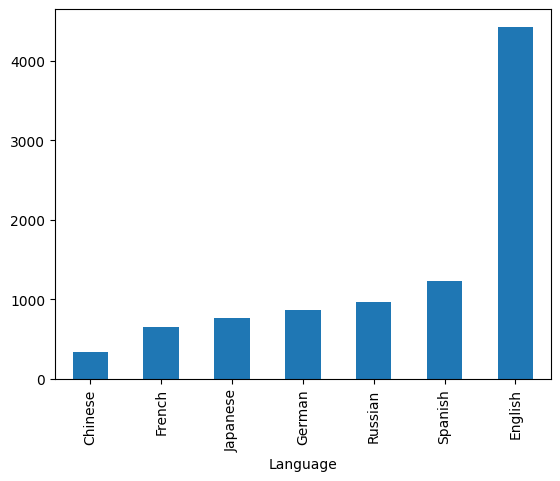

In [97]:
agg_df[['Chinese', 'English', 'French', 'German', 'Japanese', 'Russian',
       'Spanish']].mean().sort_values().plot(kind = 'bar')

English pages have the highest views.

#### **What other methods other than grid search would be suitable to get the model for all languages?**

When selecting the optimal model for time series analysis across multiple languages, other techniques besides grid search can be employed:

Estimating ARIMA Parameters Using **ACF** and **PACF**:
*  Step 1: Assess if the time series is stationary by performing an augmented Dickey-Fuller (ADF) test.
*  Step 2: If the series is stationary, consider fitting an ARMA model directly. If it is non-stationary, apply differencing to determine the value of d.
*  Step 3: Once stationarity is achieved, plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) to help identify model parameters.
*  Step 4: Use the PACF plot to determine the order of the autoregressive term (p), where the point where the plot cuts off is indicative of p.
*  Step 5: Use the ACF plot to determine the order of the moving average term (q), where the cutoff point indicates q.

These steps help guide parameter selection based on statistical characteristics of the time series, providing an alternative to exhaustive search methods like grid search.

## Insights & Recommendations

### Insights

**High English Page Views:** English pages dominate with the highest number of views, making them a priority for ad placement.

**`wikipedia.org` Leads Domain Mentions:** `wikipedia.org` accounted for 87.7% of mentions, while `wikimedia.org` and `mediawiki.org` together contributed 12.3%, indicating niche but relevant roles.

**Seasonal Patterns Detected:** Clear seasonality exists in time series data, particularly for languages like English and Japanese.

**Access Type Preferences:** Majority of access is through "all-access" (51.2%), followed by mobile-web (24.8%) and desktop (24.0%).

**Agents Dominate Access Origins:** About 75.9% of page accesses come from agents, indicating high user interaction compared to spiders.

**Stationarity Varied by Language:** Time series for Russian and Spanish were stationary, while others needed differencing.

**Trend and Seasonality Impact:** Differencing once was sufficient to make non-stationary series, like English, stationary.

**SARIMAX Performed Best with Exogenous Variables:** Incorporating campaign data improved the forecasting accuracy for English pages, achieving a MAPE of 4.05%.

**Low MAPE for Chinese and Russian:** Chinese had a MAPE of 3.07%, and Russian had a MAPE of 4.16%, indicating good model performance.

**Higher MAPE for Spanish:** The model for Spanish had a MAPE of 8.56%, suggesting room for improvement in forecasting accuracy.

**Significant Campaign Impact on Views:** Days with campaigns showed a noticeable spike in page views for English pages.

### Recommendations

**Focus Ad Placements on English Pages:** High views and low MAPE (4.05%) make English pages ideal for targeted ads.

**Target Mobile-Web and All-Access Users:** Focus ad strategies on these access types, which together account for over 75% of views.

**Incorporate Seasonal Patterns in Forecasting:** Improve model accuracy by capturing repeating trends across different languages.

**Use SARIMAX with Campaign Data:** Enhance forecasting by including external factors like promotional events for better predictions.

**Improve the Spanish Forecasting Model:** Refine the model to reduce the higher MAPE for Spanish, ensuring better prediction accuracy.

**Evaluate Ad Performance During Campaigns:** Focus on optimizing ad content and timing when campaigns significantly increase views.

**Update Models Regularly:** Regularly retrain forecasting models with new data to maintain high accuracy as trends evolve.